In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [4]:
#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)

In [5]:
import math

# def get_cre_dist_cv(msvd, means_cast, eminors,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         #get mean of all points sharing cre line and minor structure with this one (but not including)
#         meani = means_cast.loc[tuple([eminors[i],cres[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
#         meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
#         for j in range(nsamp):
#             meanj = means_cast.loc[cres[j]]
#             #t= tuple([cres[i], cres[j]])
#             if np.isin(t, rkeys).all():
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)
#     return(credist)
def get_cre_dist_cv(msvd, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
        ncr = len(np.where(cres == cres[i])[0])
        meanloocvi = meani
        meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)
def get_loss_surface(msvd,cre_dist, fraction):
    #ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = msvd.centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
    ngp = goodpairs.shape[0]
    centroids = msvd.centroids
    projs = msvd.reg_proj_vcount_norm_renorm
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        print(i)
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
    cs2 = cs[np.where(~np.isnan(cs))]    
    #ds2 = ds[np.where(~np.isnan(cs))]
    #
    source2 = source[np.where(~np.isnan(cs.flatten()))]
    target2 = target[np.where(~np.isnan(cs.flatten()))]

    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)

    ds2 = ds2 / dsnorm
    cs2 = cs2 / csnorm
    #ls2 = ls[np.where(~np.isnan(cs))]

    dc = np.asarray([ds2,cs2,ls2]).transpose()
    #ids = np.linspace(0,35, 36, dtype = int), 36)
    
    qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    #return(qqq)
    return(qqq)

def get_smoothed_losses(msvd, qqq, cre_dist):
    ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    ds2 = ds[np.where(~np.isnan(cs))]
    cs2 = cs[np.where(~np.isnan(cs))]
    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)
    
    ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = ds.shape[0]
    bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
    smoothedlosses = np.empty((nsamp,nsamp))
    smoothedlosses[:] = np.nan
    for i in range(bbbb.shape[0]):
        ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
        di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
        smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[ci, di]]))
    return(smoothedlosses)

In [6]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [7]:
from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def get_cre_similarity(msvd, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

In [8]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


In [9]:
sls = {}



In [10]:
def get_loss_surface_control(msvd,cre_dist, fraction):
    #ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = msvd.centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
    ngp = goodpairs.shape[0]
    centroids = msvd.centroids
    projs = msvd.reg_proj_vcount_norm_renorm
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        print(i)
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
    cs2 = cs[np.where(~np.isnan(cs))]    
    #ds2 = ds[np.where(~np.isnan(cs))]
    #
    source2 = source[np.where(~np.isnan(cs.flatten()))]
    target2 = target[np.where(~np.isnan(cs.flatten()))]

    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)

    ds2 = ds2 / dsnorm
    cs2 = cs2 / csnorm
    #ls2 = ls[np.where(~np.isnan(cs))]

    dc = np.asarray([ds2,cs2,ls2]).transpose()
    #ids = np.linspace(0,35, 36, dtype = int), 36)
    dc[:,1] = np.zeros(dc[:,1].shape[0])
    qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    #return(qqq)
    return(qqq)

In [11]:
frac_learn = np.ones(12)
frac_learn[4] = .01

for m in range(12):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    msvd = msvds[sid]
    cres = creline[sid]
    eminors = experiments_minor_structures[sid]
    means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
    #mean_dist = get_mean_dist(means_cast)
    cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)
    qqq = get_loss_surface_control(msvd, cre_dist2,frac_learn[m])
    sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

512
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
703
0
1
2
3
4
5
6
0
1
2
3
1089


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


1097
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


315
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624


4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505


7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372
7373
7374
7375
7376
7377
7378
7379
7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440


10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
1034

11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
1184

13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
1335

14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760
14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813
14814
14815
14816
14817
14818
14819
14820
14821
14822
14823
14824
14825
14826
14827
14828
14829
14830
14831
14832
14833
14834
14835
14836
14837
14838
14839
14840
14841
14842
14843
14844
14845
14846
14847
14848
14849
14850
14851
14852
14853
14854
14855
14856
14857
14858
14859
14860
14861
14862
14863
14864
14865
14866
14867
14868
14869
14870
14871
14872
14873
14874
14875
14876
14877
14878
14879
14880
14881
14882
14883
14884
14885
1488

16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202
16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
16213
16214
16215
16216
16217
16218
16219
16220
16221
16222
16223
16224
16225
16226
16227
16228
16229
16230
16231
16232
16233
16234
16235
16236
16237
16238
16239
16240
16241
16242
16243
16244
16245
16246
16247
16248
16249
16250
16251
16252
16253
16254
16255
16256
16257
16258
16259
16260
16261
16262
16263
16264
16265
16266
16267
16268
16269
16270
16271
16272
16273
16274
16275
16276
16277
16278
16279
16280
16281
16282
16283
16284
16285
16286
16287
16288
16289
16290
16291
16292
16293
16294
16295
16296
16297
16298
16299
16300
16301
16302
16303
16304
16305
16306
16307
16308
16309
16310
16311
16312
16313
16314
16315
16316
16317
16318
16319
16320
16321
16322
16323
16324
16325
16326
16327
16328
16329
16330
16331
16332
16333
16334
16335
16336
16337
16338
16339
16340
16341
16342
16343
16344
16345
16346
16347
16348
16349
16350
16351
16352
1635

17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
17821
17822
17823
17824
17825
17826
17827
17828
17829
17830
17831
17832
17833
17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844
17845
17846
17847
17848
17849
17850
17851
17852
17853
17854
17855
1785

19173
19174
19175
19176
19177
19178
19179
19180
19181
19182
19183
19184
19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230
19231
19232
19233
19234
19235
19236
19237
19238
19239
19240
19241
19242
19243
19244
19245
19246
19247
19248
19249
19250
19251
19252
19253
19254
19255
19256
19257
19258
19259
19260
19261
19262
19263
19264
19265
19266
19267
19268
19269
19270
19271
19272
19273
19274
19275
19276
19277
19278
19279
19280
19281
19282
19283
19284
19285
19286
19287
19288
19289
19290
19291
19292
19293
19294
19295
19296
19297
19298
19299
19300
19301
19302
19303
19304
19305
19306
19307
19308
19309
19310
19311
19312
19313
19314
19315
19316
19317
19318
19319
19320
19321
19322
19323
19324
19325
19326
19327
19328
19329
19330
19331
19332
19333
19334
19335
19336
19337
19338
1933

20618
20619
20620
20621
20622
20623
20624
20625
20626
20627
20628
20629
20630
20631
20632
20633
20634
20635
20636
20637
20638
20639
20640
20641
20642
20643
20644
20645
20646
20647
20648
20649
20650
20651
20652
20653
20654
20655
20656
20657
20658
20659
20660
20661
20662
20663
20664
20665
20666
20667
20668
20669
20670
20671
20672
20673
20674
20675
20676
20677
20678
20679
20680
20681
20682
20683
20684
20685
20686
20687
20688
20689
20690
20691
20692
20693
20694
20695
20696
20697
20698
20699
20700
20701
20702
20703
20704
20705
20706
20707
20708
20709
20710
20711
20712
20713
20714
20715
20716
20717
20718
20719
20720
20721
20722
20723
20724
20725
20726
20727
20728
20729
20730
20731
20732
20733
20734
20735
20736
20737
20738
20739
20740
20741
20742
20743
20744
20745
20746
20747
20748
20749
20750
20751
20752
20753
20754
20755
20756
20757
20758
20759
20760
20761
20762
20763
20764
20765
20766
20767
20768
20769
20770
20771
20772
20773
20774
20775
20776
20777
20778
20779
20780
20781
20782
20783
2078

22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
22161
22162
22163
22164
22165
22166
22167
22168
22169
22170
22171
22172
22173
22174
22175
22176
22177
22178
22179
22180
22181
22182
22183
22184
22185
22186
22187
22188
22189
22190
22191
22192
22193
22194
22195
22196
22197
22198
22199
22200
22201
22202
22203
22204
22205
22206
22207
22208
22209
22210
22211
22212
22213
22214
22215
22216
22217
22218
22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229
22230
22231
22232
22233
22234
22235
22236
22237
22238
22239
22240
22241
22242
22243
22244
22245
22246
22247
22248
22249
22250
22251
22252
22253
22254
22255
22256
22257
22258
22259
22260
22261
22262
22263
22264
22265
22266
22267
22268
22269
22270
22271
22272
22273
22274
22275
22276
22277
22278
22279
22280
22281
22282
22283
22284
2228

23638
23639
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
23673
23674
23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687
23688
23689
23690
23691
23692
23693
23694
23695
23696
23697
23698
23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709
23710
23711
23712
23713
23714
23715
23716
23717
23718
23719
23720
23721
23722
23723
23724
23725
23726
23727
23728
23729
23730
23731
23732
23733
23734
23735
23736
23737
23738
23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
2380

25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
2527

26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
2673

28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165
28166
28167
28168
28169
28170
28171
28172
28173
28174
28175
28176
28177
28178
28179
28180
28181
28182
28183
28184
28185
28186
28187
28188
28189
28190
28191
28192
28193
28194
28195
28196
28197
28198
28199
28200
28201
28202
28203
28204
28205
28206
28207
28208
28209
28210
28211
28212
28213
28214
28215
28216
28217
28218
28219
28220
28221
28222
28223
28224
28225
28226
28227
28228
28229
28230
28231
28232
28233
28234
28235
28236
28237
28238
28239
28240
28241
28242
28243
28244
28245
28246
28247
28248
28249
28250
28251
28252
28253
28254
28255
28256
28257
28258
28259
28260
28261
28262
28263
28264
2826

29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
29553
29554
29555
29556
29557
29558
29559
29560
29561
29562
29563
29564
29565
29566
29567
29568
29569
29570
29571
29572
29573
29574
29575
29576
29577
29578
29579
29580
29581
29582
29583
29584
29585
29586
29587
29588
29589
29590
29591
29592
29593
29594
29595
29596
29597
29598
29599
29600
29601
29602
29603
29604
29605
29606
29607
29608
29609
29610
29611
29612
29613
29614
29615
29616
29617
29618
29619
29620
29621
29622
29623
29624
29625
29626
29627
29628
29629
29630
29631
29632
29633
29634
29635
29636
29637
29638
29639
29640
29641
29642
29643
29644
29645
29646
29647
29648
29649
29650
29651
29652
29653
29654
29655
29656
29657
29658
29659
29660
29661
29662
29663
29664
29665
29666
29667
29668
29669
29670
29671
29672
29673
29674
29675
29676
29677
29678
29679
29680
29681
29682
29683
29684
29685
29686
29687
29688
29689
29690
29691
29692
29693
29694
29695
29696
29697
29698
29699
29700
29701
2970

30979
30980
30981
30982
30983
30984
30985
30986
30987
30988
30989
30990
30991
30992
30993
30994
30995
30996
30997
30998
30999
31000
31001
31002
31003
31004
31005
31006
31007
31008
31009
31010
31011
31012
31013
31014
31015
31016
31017
31018
31019
31020
31021
31022
31023
31024
31025
31026
31027
31028
31029
31030
31031
31032
31033
31034
31035
31036
31037
31038
31039
31040
31041
31042
31043
31044
31045
31046
31047
31048
31049
31050
31051
31052
31053
31054
31055
31056
31057
31058
31059
31060
31061
31062
31063
31064
31065
31066
31067
31068
31069
31070
31071
31072
31073
31074
31075
31076
31077
31078
31079
31080
31081
31082
31083
31084
31085
31086
31087
31088
31089
31090
31091
31092
31093
31094
31095
31096
31097
31098
31099
31100
31101
31102
31103
31104
31105
31106
31107
31108
31109
31110
31111
31112
31113
31114
31115
31116
31117
31118
31119
31120
31121
31122
31123
31124
31125
31126
31127
31128
31129
31130
31131
31132
31133
31134
31135
31136
31137
31138
31139
31140
31141
31142
31143
31144
3114

32464
32465
32466
32467
32468
32469
32470
32471
32472
32473
32474
32475
32476
32477
32478
32479
32480
32481
32482
32483
32484
32485
32486
32487
32488
32489
32490
32491
32492
32493
32494
32495
32496
32497
32498
32499
32500
32501
32502
32503
32504
32505
32506
32507
32508
32509
32510
32511
32512
32513
32514
32515
32516
32517
32518
32519
32520
32521
32522
32523
32524
32525
32526
32527
32528
32529
32530
32531
32532
32533
32534
32535
32536
32537
32538
32539
32540
32541
32542
32543
32544
32545
32546
32547
32548
32549
32550
32551
32552
32553
32554
32555
32556
32557
32558
32559
32560
32561
32562
32563
32564
32565
32566
32567
32568
32569
32570
32571
32572
32573
32574
32575
32576
32577
32578
32579
32580
32581
32582
32583
32584
32585
32586
32587
32588
32589
32590
32591
32592
32593
32594
32595
32596
32597
32598
32599
32600
32601
32602
32603
32604
32605
32606
32607
32608
32609
32610
32611
32612
32613
32614
32615
32616
32617
32618
32619
32620
32621
32622
32623
32624
32625
32626
32627
32628
32629
3263

33923
33924
33925
33926
33927
33928
33929
33930
33931
33932
33933
33934
33935
33936
33937
33938
33939
33940
33941
33942
33943
33944
33945
33946
33947
33948
33949
33950
33951
33952
33953
33954
33955
33956
33957
33958
33959
33960
33961
33962
33963
33964
33965
33966
33967
33968
33969
33970
33971
33972
33973
33974
33975
33976
33977
33978
33979
33980
33981
33982
33983
33984
33985
33986
33987
33988
33989
33990
33991
33992
33993
33994
33995
33996
33997
33998
33999
34000
34001
34002
34003
34004
34005
34006
34007
34008
34009
34010
34011
34012
34013
34014
34015
34016
34017
34018
34019
34020
34021
34022
34023
34024
34025
34026
34027
34028
34029
34030
34031
34032
34033
34034
34035
34036
34037
34038
34039
34040
34041
34042
34043
34044
34045
34046
34047
34048
34049
34050
34051
34052
34053
34054
34055
34056
34057
34058
34059
34060
34061
34062
34063
34064
34065
34066
34067
34068
34069
34070
34071
34072
34073
34074
34075
34076
34077
34078
34079
34080
34081
34082
34083
34084
34085
34086
34087
34088
3408

35367
35368
35369
35370
35371
35372
35373
35374
35375
35376
35377
35378
35379
35380
35381
35382
35383
35384
35385
35386
35387
35388
35389
35390
35391
35392
35393
35394
35395
35396
35397
35398
35399
35400
35401
35402
35403
35404
35405
35406
35407
35408
35409
35410
35411
35412
35413
35414
35415
35416
35417
35418
35419
35420
35421
35422
35423
35424
35425
35426
35427
35428
35429
35430
35431
35432
35433
35434
35435
35436
35437
35438
35439
35440
35441
35442
35443
35444
35445
35446
35447
35448
35449
35450
35451
35452
35453
35454
35455
35456
35457
35458
35459
35460
35461
35462
35463
35464
35465
35466
35467
35468
35469
35470
35471
35472
35473
35474
35475
35476
35477
35478
35479
35480
35481
35482
35483
35484
35485
35486
35487
35488
35489
35490
35491
35492
35493
35494
35495
35496
35497
35498
35499
35500
35501
35502
35503
35504
35505
35506
35507
35508
35509
35510
35511
35512
35513
35514
35515
35516
35517
35518
35519
35520
35521
35522
35523
35524
35525
35526
35527
35528
35529
35530
35531
35532
3553

36850
36851
36852
36853
36854
36855
36856
36857
36858
36859
36860
36861
36862
36863
36864
36865
36866
36867
36868
36869
36870
36871
36872
36873
36874
36875
36876
36877
36878
36879
36880
36881
36882
36883
36884
36885
36886
36887
36888
36889
36890
36891
36892
36893
36894
36895
36896
36897
36898
36899
36900
36901
36902
36903
36904
36905
36906
36907
36908
36909
36910
36911
36912
36913
36914
36915
36916
36917
36918
36919
36920
36921
36922
36923
36924
36925
36926
36927
36928
36929
36930
36931
36932
36933
36934
36935
36936
36937
36938
36939
36940
36941
36942
36943
36944
36945
36946
36947
36948
36949
36950
36951
36952
36953
36954
36955
36956
36957
36958
36959
36960
36961
36962
36963
36964
36965
36966
36967
36968
36969
36970
36971
36972
36973
36974
36975
36976
36977
36978
36979
36980
36981
36982
36983
36984
36985
36986
36987
36988
36989
36990
36991
36992
36993
36994
36995
36996
36997
36998
36999
37000
37001
37002
37003
37004
37005
37006
37007
37008
37009
37010
37011
37012
37013
37014
37015
3701

38336
38337
38338
38339
38340
38341
38342
38343
38344
38345
38346
38347
38348
38349
38350
38351
38352
38353
38354
38355
38356
38357
38358
38359
38360
38361
38362
38363
38364
38365
38366
38367
38368
38369
38370
38371
38372
38373
38374
38375
38376
38377
38378
38379
38380
38381
38382
38383
38384
38385
38386
38387
38388
38389
38390
38391
38392
38393
38394
38395
38396
38397
38398
38399
38400
38401
38402
38403
38404
38405
38406
38407
38408
38409
38410
38411
38412
38413
38414
38415
38416
38417
38418
38419
38420
38421
38422
38423
38424
38425
38426
38427
38428
38429
38430
38431
38432
38433
38434
38435
38436
38437
38438
38439
38440
38441
38442
38443
38444
38445
38446
38447
38448
38449
38450
38451
38452
38453
38454
38455
38456
38457
38458
38459
38460
38461
38462
38463
38464
38465
38466
38467
38468
38469
38470
38471
38472
38473
38474
38475
38476
38477
38478
38479
38480
38481
38482
38483
38484
38485
38486
38487
38488
38489
38490
38491
38492
38493
38494
38495
38496
38497
38498
38499
38500
38501
3850

39831
39832
39833
39834
39835
39836
39837
39838
39839
39840
39841
39842
39843
39844
39845
39846
39847
39848
39849
39850
39851
39852
39853
39854
39855
39856
39857
39858
39859
39860
39861
39862
39863
39864
39865
39866
39867
39868
39869
39870
39871
39872
39873
39874
39875
39876
39877
39878
39879
39880
39881
39882
39883
39884
39885
39886
39887
39888
39889
39890
39891
39892
39893
39894
39895
39896
39897
39898
39899
39900
39901
39902
39903
39904
39905
39906
39907
39908
39909
39910
39911
39912
39913
39914
39915
39916
39917
39918
39919
39920
39921
39922
39923
39924
39925
39926
39927
39928
39929
39930
39931
39932
39933
39934
39935
39936
39937
39938
39939
39940
39941
39942
39943
39944
39945
39946
39947
39948
39949
39950
39951
39952
39953
39954
39955
39956
39957
39958
39959
39960
39961
39962
39963
39964
39965
39966
39967
39968
39969
39970
39971
39972
39973
39974
39975
39976
39977
39978
39979
39980
39981
39982
39983
39984
39985
39986
39987
39988
39989
39990
39991
39992
39993
39994
39995
39996
3999

41283
41284
41285
41286
41287
41288
41289
41290
41291
41292
41293
41294
41295
41296
41297
41298
41299
41300
41301
41302
41303
41304
41305
41306
41307
41308
41309
41310
41311
41312
41313
41314
41315
41316
41317
41318
41319
41320
41321
41322
41323
41324
41325
41326
41327
41328
41329
41330
41331
41332
41333
41334
41335
41336
41337
41338
41339
41340
41341
41342
41343
41344
41345
41346
41347
41348
41349
41350
41351
41352
41353
41354
41355
41356
41357
41358
41359
41360
41361
41362
41363
41364
41365
41366
41367
41368
41369
41370
41371
41372
41373
41374
41375
41376
41377
41378
41379
41380
41381
41382
41383
41384
41385
41386
41387
41388
41389
41390
41391
41392
41393
41394
41395
41396
41397
41398
41399
41400
41401
41402
41403
41404
41405
41406
41407
41408
41409
41410
41411
41412
41413
41414
41415
41416
41417
41418
41419
41420
41421
41422
41423
41424
41425
41426
41427
41428
41429
41430
41431
41432
41433
41434
41435
41436
41437
41438
41439
41440
41441
41442
41443
41444
41445
41446
41447
41448
4144

42737
42738
42739
42740
42741
42742
42743
42744
42745
42746
42747
42748
42749
42750
42751
42752
42753
42754
42755
42756
42757
42758
42759
42760
42761
42762
42763
42764
42765
42766
42767
42768
42769
42770
42771
42772
42773
42774
42775
42776
42777
42778
42779
42780
42781
42782
42783
42784
42785
42786
42787
42788
42789
42790
42791
42792
42793
42794
42795
42796
42797
42798
42799
42800
42801
42802
42803
42804
42805
42806
42807
42808
42809
42810
42811
42812
42813
42814
42815
42816
42817
42818
42819
42820
42821
42822
42823
42824
42825
42826
42827
42828
42829
42830
42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
42843
42844
42845
42846
42847
42848
42849
42850
42851
42852
42853
42854
42855
42856
42857
42858
42859
42860
42861
42862
42863
42864
42865
42866
42867
42868
42869
42870
42871
42872
42873
42874
42875
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
4290

44263
44264
44265
44266
44267
44268
44269
44270
44271
44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283
44284
44285
44286
44287
44288
44289
44290
44291
44292
44293
44294
44295
44296
44297
44298
44299
44300
44301
44302
44303
44304
44305
44306
44307
44308
44309
44310
44311
44312
44313
44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
44335
44336
44337
44338
44339
44340
44341
44342
44343
44344
44345
44346
44347
44348
44349
44350
44351
44352
44353
44354
44355
44356
44357
44358
44359
44360
44361
44362
44363
44364
44365
44366
44367
44368
44369
44370
44371
44372
44373
44374
44375
44376
44377
44378
44379
44380
44381
44382
44383
44384
44385
44386
44387
44388
44389
44390
44391
44392
44393
44394
44395
44396
44397
44398
44399
44400
44401
44402
44403
44404
44405
44406
44407
44408
44409
44410
44411
44412
44413
44414
44415
44416
44417
44418
44419
44420
44421
44422
44423
44424
44425
44426
44427
44428
4442

45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784
45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
45798
45799
45800
45801
45802
45803
45804
45805
45806
45807
45808
45809
45810
45811
45812
45813
45814
45815
45816
45817
45818
45819
45820
45821
45822
45823
45824
45825
45826
45827
45828
45829
45830
45831
45832
45833
45834
45835
45836
45837
45838
45839
45840
45841
45842
45843
45844
45845
45846
45847
45848
45849
45850
45851
45852
45853
45854
45855
45856
45857
45858
45859
45860
45861
45862
45863
45864
45865
45866
45867
45868
4586

47213
47214
47215
47216
47217
47218
47219
47220
47221
47222
47223
47224
47225
47226
47227
47228
47229
47230
47231
47232
47233
47234
47235
47236
47237
47238
47239
47240
47241
47242
47243
47244
47245
47246
47247
47248
47249
47250
47251
47252
47253
47254
47255
47256
47257
47258
47259
47260
47261
47262
47263
47264
47265
47266
47267
47268
47269
47270
47271
47272
47273
47274
47275
47276
47277
47278
47279
47280
47281
47282
47283
47284
47285
47286
47287
47288
47289
47290
47291
47292
47293
47294
47295
47296
47297
47298
47299
47300
47301
47302
47303
47304
47305
47306
47307
47308
47309
47310
47311
47312
47313
47314
47315
47316
47317
47318
47319
47320
47321
47322
47323
47324
47325
47326
47327
47328
47329
47330
47331
47332
47333
47334
47335
47336
47337
47338
47339
47340
47341
47342
47343
47344
47345
47346
47347
47348
47349
47350
47351
47352
47353
47354
47355
47356
47357
47358
47359
47360
47361
47362
47363
47364
47365
47366
47367
47368
47369
47370
47371
47372
47373
47374
47375
47376
47377
47378
4737

48671
48672
48673
48674
48675
48676
48677
48678
48679
48680
48681
48682
48683
48684
48685
48686
48687
48688
48689
48690
48691
48692
48693
48694
48695
48696
48697
48698
48699
48700
48701
48702
48703
48704
48705
48706
48707
48708
48709
48710
48711
48712
48713
48714
48715
48716
48717
48718
48719
48720
48721
48722
48723
48724
48725
48726
48727
48728
48729
48730
48731
48732
48733
48734
48735
48736
48737
48738
48739
48740
48741
48742
48743
48744
48745
48746
48747
48748
48749
48750
48751
48752
48753
48754
48755
48756
48757
48758
48759
48760
48761
48762
48763
48764
48765
48766
48767
48768
48769
48770
48771
48772
48773
48774
48775
48776
48777
48778
48779
48780
48781
48782
48783
48784
48785
48786
48787
48788
48789
48790
48791
48792
48793
48794
48795
48796
48797
48798
48799
48800
48801
48802
48803
48804
48805
48806
48807
48808
48809
48810
48811
48812
48813
48814
48815
48816
48817
48818
48819
48820
48821
48822
48823
48824
48825
48826
48827
48828
48829
48830
48831
48832
48833
48834
48835
48836
4883

50169
50170
50171
50172
50173
50174
50175
50176
50177
50178
50179
50180
50181
50182
50183
50184
50185
50186
50187
50188
50189
50190
50191
50192
50193
50194
50195
50196
50197
50198
50199
50200
50201
50202
50203
50204
50205
50206
50207
50208
50209
50210
50211
50212
50213
50214
50215
50216
50217
50218
50219
50220
50221
50222
50223
50224
50225
50226
50227
50228
50229
50230
50231
50232
50233
50234
50235
50236
50237
50238
50239
50240
50241
50242
50243
50244
50245
50246
50247
50248
50249
50250
50251
50252
50253
50254
50255
50256
50257
50258
50259
50260
50261
50262
50263
50264
50265
50266
50267
50268
50269
50270
50271
50272
50273
50274
50275
50276
50277
50278
50279
50280
50281
50282
50283
50284
50285
50286
50287
50288
50289
50290
50291
50292
50293
50294
50295
50296
50297
50298
50299
50300
50301
50302
50303
50304
50305
50306
50307
50308
50309
50310
50311
50312
50313
50314
50315
50316
50317
50318
50319
50320
50321
50322
50323
50324
50325
50326
50327
50328
50329
50330
50331
50332
50333
50334
5033

51692
51693
51694
51695
51696
51697
51698
51699
51700
51701
51702
51703
51704
51705
51706
51707
51708
51709
51710
51711
51712
51713
51714
51715
51716
51717
51718
51719
51720
51721
51722
51723
51724
51725
51726
51727
51728
51729
51730
51731
51732
51733
51734
51735
51736
51737
51738
51739
51740
51741
51742
51743
51744
51745
51746
51747
51748
51749
51750
51751
51752
51753
51754
51755
51756
51757
51758
51759
51760
51761
51762
51763
51764
51765
51766
51767
51768
51769
51770
51771
51772
51773
51774
51775
51776
51777
51778
51779
51780
51781
51782
51783
51784
51785
51786
51787
51788
51789
51790
51791
51792
51793
51794
51795
51796
51797
51798
51799
51800
51801
51802
51803
51804
51805
51806
51807
51808
51809
51810
51811
51812
51813
51814
51815
51816
51817
51818
51819
51820
51821
51822
51823
51824
51825
51826
51827
51828
51829
51830
51831
51832
51833
51834
51835
51836
51837
51838
51839
51840
51841
51842
51843
51844
51845
51846
51847
51848
51849
51850
51851
51852
51853
51854
51855
51856
51857
5185

53182
53183
53184
53185
53186
53187
53188
53189
53190
53191
53192
53193
53194
53195
53196
53197
53198
53199
53200
53201
53202
53203
53204
53205
53206
53207
53208
53209
53210
53211
53212
53213
53214
53215
53216
53217
53218
53219
53220
53221
53222
53223
53224
53225
53226
53227
53228
53229
53230
53231
53232
53233
53234
53235
53236
53237
53238
53239
53240
53241
53242
53243
53244
53245
53246
53247
53248
53249
53250
53251
53252
53253
53254
53255
53256
53257
53258
53259
53260
53261
53262
53263
53264
53265
53266
53267
53268
53269
53270
53271
53272
53273
53274
53275
53276
53277
53278
53279
53280
53281
53282
53283
53284
53285
53286
53287
53288
53289
53290
53291
53292
53293
53294
53295
53296
53297
53298
53299
53300
53301
53302
53303
53304
53305
53306
53307
53308
53309
53310
53311
53312
53313
53314
53315
53316
53317
53318
53319
53320
53321
53322
53323
53324
53325
53326
53327
53328
53329
53330
53331
53332
53333
53334
53335
53336
53337
53338
53339
53340
53341
53342
53343
53344
53345
53346
53347
5334

54653
54654
54655
54656
54657
54658
54659
54660
54661
54662
54663
54664
54665
54666
54667
54668
54669
54670
54671
54672
54673
54674
54675
54676
54677
54678
54679
54680
54681
54682
54683
54684
54685
54686
54687
54688
54689
54690
54691
54692
54693
54694
54695
54696
54697
54698
54699
54700
54701
54702
54703
54704
54705
54706
54707
54708
54709
54710
54711
54712
54713
54714
54715
54716
54717
54718
54719
54720
54721
54722
54723
54724
54725
54726
54727
54728
54729
54730
54731
54732
54733
54734
54735
54736
54737
54738
54739
54740
54741
54742
54743
54744
54745
54746
54747
54748
54749
54750
54751
54752
54753
54754
54755
54756
54757
54758
54759
54760
54761
54762
54763
54764
54765
54766
54767
54768
54769
54770
54771
54772
54773
54774
54775
54776
54777
54778
54779
54780
54781
54782
54783
54784
54785
54786
54787
54788
54789
54790
54791
54792
54793
54794
54795
54796
54797
54798
54799
54800
54801
54802
54803
54804
54805
54806
54807
54808
54809
54810
54811
54812
54813
54814
54815
54816
54817
54818
5481

56164
56165
56166
56167
56168
56169
56170
56171
56172
56173
56174
56175
56176
56177
56178
56179
56180
56181
56182
56183
56184
56185
56186
56187
56188
56189
56190
56191
56192
56193
56194
56195
56196
56197
56198
56199
56200
56201
56202
56203
56204
56205
56206
56207
56208
56209
56210
56211
56212
56213
56214
56215
56216
56217
56218
56219
56220
56221
56222
56223
56224
56225
56226
56227
56228
56229
56230
56231
56232
56233
56234
56235
56236
56237
56238
56239
56240
56241
56242
56243
56244
56245
56246
56247
56248
56249
56250
56251
56252
56253
56254
56255
56256
56257
56258
56259
56260
56261
56262
56263
56264
56265
56266
56267
56268
56269
56270
56271
56272
56273
56274
56275
56276
56277
56278
56279
56280
56281
56282
56283
56284
56285
56286
56287
56288
56289
56290
56291
56292
56293
56294
56295
56296
56297
56298
56299
56300
56301
56302
56303
56304
56305
56306
56307
56308
56309
56310
56311
56312
56313
56314
56315
56316
56317
56318
56319
56320
56321
56322
56323
56324
56325
56326
56327
56328
56329
5633

57549
57550
57551
57552
57553
57554
57555
57556
57557
57558
57559
57560
57561
57562
57563
57564
57565
57566
57567
57568
57569
57570
57571
57572
57573
57574
57575
57576
57577
57578
57579
57580
57581
57582
57583
57584
57585
57586
57587
57588
57589
57590
57591
57592
57593
57594
57595
57596
57597
57598
57599
57600
57601
57602
57603
57604
57605
57606
57607
57608
57609
57610
57611
57612
57613
57614
57615
57616
57617
57618
57619
57620
57621
57622
57623
57624
57625
57626
57627
57628
57629
57630
57631
57632
57633
57634
57635
57636
57637
57638
57639
57640
57641
57642
57643
57644
57645
57646
57647
57648
57649
57650
57651
57652
57653
57654
57655
57656
57657
57658
57659
57660
57661
57662
57663
57664
57665
57666
57667
57668
57669
57670
57671
57672
57673
57674
57675
57676
57677
57678
57679
57680
57681
57682
57683
57684
57685
57686
57687
57688
57689
57690
57691
57692
57693
57694
57695
57696
57697
57698
57699
57700
57701
57702
57703
57704
57705
57706
57707
57708
57709
57710
57711
57712
57713
57714
5771

58988
58989
58990
58991
58992
58993
58994
58995
58996
58997
58998
58999
59000
59001
59002
59003
59004
59005
59006
59007
59008
59009
59010
59011
59012
59013
59014
59015
59016
59017
59018
59019
59020
59021
59022
59023
59024
59025
59026
59027
59028
59029
59030
59031
59032
59033
59034
59035
59036
59037
59038
59039
59040
59041
59042
59043
59044
59045
59046
59047
59048
59049
59050
59051
59052
59053
59054
59055
59056
59057
59058
59059
59060
59061
59062
59063
59064
59065
59066
59067
59068
59069
59070
59071
59072
59073
59074
59075
59076
59077
59078
59079
59080
59081
59082
59083
59084
59085
59086
59087
59088
59089
59090
59091
59092
59093
59094
59095
59096
59097
59098
59099
59100
59101
59102
59103
59104
59105
59106
59107
59108
59109
59110
59111
59112
59113
59114
59115
59116
59117
59118
59119
59120
59121
59122
59123
59124
59125
59126
59127
59128
59129
59130
59131
59132
59133
59134
59135
59136
59137
59138
59139
59140
59141
59142
59143
59144
59145
59146
59147
59148
59149
59150
59151
59152
59153
5915

60405
60406
60407
60408
60409
60410
60411
60412
60413
60414
60415
60416
60417
60418
60419
60420
60421
60422
60423
60424
60425
60426
60427
60428
60429
60430
60431
60432
60433
60434
60435
60436
60437
60438
60439
60440
60441
60442
60443
60444
60445
60446
60447
60448
60449
60450
60451
60452
60453
60454
60455
60456
60457
60458
60459
60460
60461
60462
60463
60464
60465
60466
60467
60468
60469
60470
60471
60472
60473
60474
60475
60476
60477
60478
60479
60480
60481
60482
60483
60484
60485
60486
60487
60488
60489
60490
60491
60492
60493
60494
60495
60496
60497
60498
60499
60500
60501
60502
60503
60504
60505
60506
60507
60508
60509
60510
60511
60512
60513
60514
60515
60516
60517
60518
60519
60520
60521
60522
60523
60524
60525
60526
60527
60528
60529
60530
60531
60532
60533
60534
60535
60536
60537
60538
60539
60540
60541
60542
60543
60544
60545
60546
60547
60548
60549
60550
60551
60552
60553
60554
60555
60556
60557
60558
60559
60560
60561
60562
60563
60564
60565
60566
60567
60568
60569
60570
6057

61901
61902
61903
61904
61905
61906
61907
61908
61909
61910
61911
61912
61913
61914
61915
61916
61917
61918
61919
61920
61921
61922
61923
61924
61925
61926
61927
61928
61929
61930
61931
61932
61933
61934
61935
61936
61937
61938
61939
61940
61941
61942
61943
61944
61945
61946
61947
61948
61949
61950
61951
61952
61953
61954
61955
61956
61957
61958
61959
61960
61961
61962
61963
61964
61965
61966
61967
61968
61969
61970
61971
61972
61973
61974
61975
61976
61977
61978
61979
61980
61981
61982
61983
61984
61985
61986
61987
61988
61989
61990
61991
61992
61993
61994
61995
61996
61997
61998
61999
62000
62001
62002
62003
62004
62005
62006
62007
62008
62009
62010
62011
62012
62013
62014
62015
62016
62017
62018
62019
62020
62021
62022
62023
62024
62025
62026
62027
62028
62029
62030
62031
62032
62033
62034
62035
62036
62037
62038
62039
62040
62041
62042
62043
62044
62045
62046
62047
62048
62049
62050
62051
62052
62053
62054
62055
62056
62057
62058
62059
62060
62061
62062
62063
62064
62065
62066
6206

63345
63346
63347
63348
63349
63350
63351
63352
63353
63354
63355
63356
63357
63358
63359
63360
63361
63362
63363
63364
63365
63366
63367
63368
63369
63370
63371
63372
63373
63374
63375
63376
63377
63378
63379
63380
63381
63382
63383
63384
63385
63386
63387
63388
63389
63390
63391
63392
63393
63394
63395
63396
63397
63398
63399
63400
63401
63402
63403
63404
63405
63406
63407
63408
63409
63410
63411
63412
63413
63414
63415
63416
63417
63418
63419
63420
63421
63422
63423
63424
63425
63426
63427
63428
63429
63430
63431
63432
63433
63434
63435
63436
63437
63438
63439
63440
63441
63442
63443
63444
63445
63446
63447
63448
63449
63450
63451
63452
63453
63454
63455
63456
63457
63458
63459
63460
63461
63462
63463
63464
63465
63466
63467
63468
63469
63470
63471
63472
63473
63474
63475
63476
63477
63478
63479
63480
63481
63482
63483
63484
63485
63486
63487
63488
63489
63490
63491
63492
63493
63494
63495
63496
63497
63498
63499
63500
63501
63502
63503
63504
63505
63506
63507
63508
63509
63510
6351

64872
64873
64874
64875
64876
64877
64878
64879
64880
64881
64882
64883
64884
64885
64886
64887
64888
64889
64890
64891
64892
64893
64894
64895
64896
64897
64898
64899
64900
64901
64902
64903
64904
64905
64906
64907
64908
64909
64910
64911
64912
64913
64914
64915
64916
64917
64918
64919
64920
64921
64922
64923
64924
64925
64926
64927
64928
64929
64930
64931
64932
64933
64934
64935
64936
64937
64938
64939
64940
64941
64942
64943
64944
64945
64946
64947
64948
64949
64950
64951
64952
64953
64954
64955
64956
64957
64958
64959
64960
64961
64962
64963
64964
64965
64966
64967
64968
64969
64970
64971
64972
64973
64974
64975
64976
64977
64978
64979
64980
64981
64982
64983
64984
64985
64986
64987
64988
64989
64990
64991
64992
64993
64994
64995
64996
64997
64998
64999
65000
65001
65002
65003
65004
65005
65006
65007
65008
65009
65010
65011
65012
65013
65014
65015
65016
65017
65018
65019
65020
65021
65022
65023
65024
65025
65026
65027
65028
65029
65030
65031
65032
65033
65034
65035
65036
65037
6503

66371
66372
66373
66374
66375
66376
66377
66378
66379
66380
66381
66382
66383
66384
66385
66386
66387
66388
66389
66390
66391
66392
66393
66394
66395
66396
66397
66398
66399
66400
66401
66402
66403
66404
66405
66406
66407
66408
66409
66410
66411
66412
66413
66414
66415
66416
66417
66418
66419
66420
66421
66422
66423
66424
66425
66426
66427
66428
66429
66430
66431
66432
66433
66434
66435
66436
66437
66438
66439
66440
66441
66442
66443
66444
66445
66446
66447
66448
66449
66450
66451
66452
66453
66454
66455
66456
66457
66458
66459
66460
66461
66462
66463
66464
66465
66466
66467
66468
66469
66470
66471
66472
66473
66474
66475
66476
66477
66478
66479
66480
66481
66482
66483
66484
66485
66486
66487
66488
66489
66490
66491
66492
66493
66494
66495
66496
66497
66498
66499
66500
66501
66502
66503
66504
66505
66506
66507
66508
66509
66510
66511
66512
66513
66514
66515
66516
66517
66518
66519
66520
66521
66522
66523
66524
66525
66526
66527
66528
66529
66530
66531
66532
66533
66534
66535
66536
6653

67885
67886
67887
67888
67889
67890
67891
67892
67893
67894
67895
67896
67897
67898
67899
67900
67901
67902
67903
67904
67905
67906
67907
67908
67909
67910
67911
67912
67913
67914
67915
67916
67917
67918
67919
67920
67921
67922
67923
67924
67925
67926
67927
67928
67929
67930
67931
67932
67933
67934
67935
67936
67937
67938
67939
67940
67941
67942
67943
67944
67945
67946
67947
67948
67949
67950
67951
67952
67953
67954
67955
67956
67957
67958
67959
67960
67961
67962
67963
67964
67965
67966
67967
67968
67969
67970
67971
67972
67973
67974
67975
67976
67977
67978
67979
67980
67981
67982
67983
67984
67985
67986
67987
67988
67989
67990
67991
67992
67993
67994
67995
67996
67997
67998
67999
68000
68001
68002
68003
68004
68005
68006
68007
68008
68009
68010
68011
68012
68013
68014
68015
68016
68017
68018
68019
68020
68021
68022
68023
68024
68025
68026
68027
68028
68029
68030
68031
68032
68033
68034
68035
68036
68037
68038
68039
68040
68041
68042
68043
68044
68045
68046
68047
68048
68049
68050
6805

69429
69430
69431
69432
69433
69434
69435
69436
69437
69438
69439
69440
69441
69442
69443
69444
69445
69446
69447
69448
69449
69450
69451
69452
69453
69454
69455
69456
69457
69458
69459
69460
69461
69462
69463
69464
69465
69466
69467
69468
69469
69470
69471
69472
69473
69474
69475
69476
69477
69478
69479
69480
69481
69482
69483
69484
69485
69486
69487
69488
69489
69490
69491
69492
69493
69494
69495
69496
69497
69498
69499
69500
69501
69502
69503
69504
69505
69506
69507
69508
69509
69510
69511
69512
69513
69514
69515
69516
69517
69518
69519
69520
69521
69522
69523
69524
69525
69526
69527
69528
69529
69530
69531
69532
69533
69534
69535
69536
69537
69538
69539
69540
69541
69542
69543
69544
69545
69546
69547
69548
69549
69550
69551
69552
69553
69554
69555
69556
69557
69558
69559
69560
69561
69562
69563
69564
69565
69566
69567
69568
69569
69570
69571
69572
69573
69574
69575
69576
69577
69578
69579
69580
69581
69582
69583
69584
69585
69586
69587
69588
69589
69590
69591
69592
69593
69594
6959

70933
70934
70935
70936
70937
70938
70939
70940
70941
70942
70943
70944
70945
70946
70947
70948
70949
70950
70951
70952
70953
70954
70955
70956
70957
70958
70959
70960
70961
70962
70963
70964
70965
70966
70967
70968
70969
70970
70971
70972
70973
70974
70975
70976
70977
70978
70979
70980
70981
70982
70983
70984
70985
70986
70987
70988
70989
70990
70991
70992
70993
70994
70995
70996
70997
70998
70999
71000
71001
71002
71003
71004
71005
71006
71007
71008
71009
71010
71011
71012
71013
71014
71015
71016
71017
71018
71019
71020
71021
71022
71023
71024
71025
71026
71027
71028
71029
71030
71031
71032
71033
71034
71035
71036
71037
71038
71039
71040
71041
71042
71043
71044
71045
71046
71047
71048
71049
71050
71051
71052
71053
71054
71055
71056
71057
71058
71059
71060
71061
71062
71063
71064
71065
71066
71067
71068
71069
71070
71071
71072
71073
71074
71075
71076
71077
71078
71079
71080
71081
71082
71083
71084
71085
71086
71087
71088
71089
71090
71091
71092
71093
71094
71095
71096
71097
71098
7109

73749
73750
73751
73752
73753
73754
73755
73756
73757
73758
73759
73760
73761
73762
73763
73764
73765
73766
73767
73768
73769
73770
73771
73772
73773
73774
73775
73776
73777
73778
73779
73780
73781
73782
73783
73784
73785
73786
73787
73788
73789
73790
73791
73792
73793
73794
73795
73796
73797
73798
73799
73800
73801
73802
73803
73804
73805
73806
73807
73808
73809
73810
73811
73812
73813
73814
73815
73816
73817
73818
73819
73820
73821
73822
73823
73824
73825
73826
73827
73828
73829
73830
73831
73832
73833
73834
73835
73836
73837
73838
73839
73840
73841
73842
73843
73844
73845
73846
73847
73848
73849
73850
73851
73852
73853
73854
73855
73856
73857
73858
73859
73860
73861
73862
73863
73864
73865
73866
73867
73868
73869
73870
73871
73872
73873
73874
73875
73876
73877
73878
73879
73880
73881
73882
73883
73884
73885
73886
73887
73888
73889
73890
73891
73892
73893
73894
73895
73896
73897
73898
73899
73900
73901
73902
73903
73904
73905
73906
73907
73908
73909
73910
73911
73912
73913
73914
7391

75249
75250
75251
75252
75253
75254
75255
75256
75257
75258
75259
75260
75261
75262
75263
75264
75265
75266
75267
75268
75269
75270
75271
75272
75273
75274
75275
75276
75277
75278
75279
75280
75281
75282
75283
75284
75285
75286
75287
75288
75289
75290
75291
75292
75293
75294
75295
75296
75297
75298
75299
75300
75301
75302
75303
75304
75305
75306
75307
75308
75309
75310
75311
75312
75313
75314
75315
75316
75317
75318
75319
75320
75321
75322
75323
75324
75325
75326
75327
75328
75329
75330
75331
75332
75333
75334
75335
75336
75337
75338
75339
75340
75341
75342
75343
75344
75345
75346
75347
75348
75349
75350
75351
75352
75353
75354
75355
75356
75357
75358
75359
75360
75361
75362
75363
75364
75365
75366
75367
75368
75369
75370
75371
75372
75373
75374
75375
75376
75377
75378
75379
75380
75381
75382
75383
75384
75385
75386
75387
75388
75389
75390
75391
75392
75393
75394
75395
75396
75397
75398
75399
75400
75401
75402
75403
75404
75405
75406
75407
75408
75409
75410
75411
75412
75413
75414
7541

76750
76751
76752
76753
76754
76755
76756
76757
76758
76759
76760
76761
76762
76763
76764
76765
76766
76767
76768
76769
76770
76771
76772
76773
76774
76775
76776
76777
76778
76779
76780
76781
76782
76783
76784
76785
76786
76787
76788
76789
76790
76791
76792
76793
76794
76795
76796
76797
76798
76799
76800
76801
76802
76803
76804
76805
76806
76807
76808
76809
76810
76811
76812
76813
76814
76815
76816
76817
76818
76819
76820
76821
76822
76823
76824
76825
76826
76827
76828
76829
76830
76831
76832
76833
76834
76835
76836
76837
76838
76839
76840
76841
76842
76843
76844
76845
76846
76847
76848
76849
76850
76851
76852
76853
76854
76855
76856
76857
76858
76859
76860
76861
76862
76863
76864
76865
76866
76867
76868
76869
76870
76871
76872
76873
76874
76875
76876
76877
76878
76879
76880
76881
76882
76883
76884
76885
76886
76887
76888
76889
76890
76891
76892
76893
76894
76895
76896
76897
76898
76899
76900
76901
76902
76903
76904
76905
76906
76907
76908
76909
76910
76911
76912
76913
76914
76915
7691

78261
78262
78263
78264
78265
78266
78267
78268
78269
78270
78271
78272
78273
78274
78275
78276
78277
78278
78279
78280
78281
78282
78283
78284
78285
78286
78287
78288
78289
78290
78291
78292
78293
78294
78295
78296
78297
78298
78299
78300
78301
78302
78303
78304
78305
78306
78307
78308
78309
78310
78311
78312
78313
78314
78315
78316
78317
78318
78319
78320
78321
78322
78323
78324
78325
78326
78327
78328
78329
78330
78331
78332
78333
78334
78335
78336
78337
78338
78339
78340
78341
78342
78343
78344
78345
78346
78347
78348
78349
78350
78351
78352
78353
78354
78355
78356
78357
78358
78359
78360
78361
78362
78363
78364
78365
78366
78367
78368
78369
78370
78371
78372
78373
78374
78375
78376
78377
78378
78379
78380
78381
78382
78383
78384
78385
78386
78387
78388
78389
78390
78391
78392
78393
78394
78395
78396
78397
78398
78399
78400
78401
78402
78403
78404
78405
78406
78407
78408
78409
78410
78411
78412
78413
78414
78415
78416
78417
78418
78419
78420
78421
78422
78423
78424
78425
78426
7842

79631
79632
79633
79634
79635
79636
79637
79638
79639
79640
79641
79642
79643
79644
79645
79646
79647
79648
79649
79650
79651
79652
79653
79654
79655
79656
79657
79658
79659
79660
79661
79662
79663
79664
79665
79666
79667
79668
79669
79670
79671
79672
79673
79674
79675
79676
79677
79678
79679
79680
79681
79682
79683
79684
79685
79686
79687
79688
79689
79690
79691
79692
79693
79694
79695
79696
79697
79698
79699
79700
79701
79702
79703
79704
79705
79706
79707
79708
79709
79710
79711
79712
79713
79714
79715
79716
79717
79718
79719
79720
79721
79722
79723
79724
79725
79726
79727
79728
79729
79730
79731
79732
79733
79734
79735
79736
79737
79738
79739
79740
79741
79742
79743
79744
79745
79746
79747
79748
79749
79750
79751
79752
79753
79754
79755
79756
79757
79758
79759
79760
79761
79762
79763
79764
79765
79766
79767
79768
79769
79770
79771
79772
79773
79774
79775
79776
79777
79778
79779
79780
79781
79782
79783
79784
79785
79786
79787
79788
79789
79790
79791
79792
79793
79794
79795
79796
7979

81092
81093
81094
81095
81096
81097
81098
81099
81100
81101
81102
81103
81104
81105
81106
81107
81108
81109
81110
81111
81112
81113
81114
81115
81116
81117
81118
81119
81120
81121
81122
81123
81124
81125
81126
81127
81128
81129
81130
81131
81132
81133
81134
81135
81136
81137
81138
81139
81140
81141
81142
81143
81144
81145
81146
81147
81148
81149
81150
81151
81152
81153
81154
81155
81156
81157
81158
81159
81160
81161
81162
81163
81164
81165
81166
81167
81168
81169
81170
81171
81172
81173
81174
81175
81176
81177
81178
81179
81180
81181
81182
81183
81184
81185
81186
81187
81188
81189
81190
81191
81192
81193
81194
81195
81196
81197
81198
81199
81200
81201
81202
81203
81204
81205
81206
81207
81208
81209
81210
81211
81212
81213
81214
81215
81216
81217
81218
81219
81220
81221
81222
81223
81224
81225
81226
81227
81228
81229
81230
81231
81232
81233
81234
81235
81236
81237
81238
81239
81240
81241
81242
81243
81244
81245
81246
81247
81248
81249
81250
81251
81252
81253
81254
81255
81256
81257
8125

82606
82607
82608
82609
82610
82611
82612
82613
82614
82615
82616
82617
82618
82619
82620
82621
82622
82623
82624
82625
82626
82627
82628
82629
82630
82631
82632
82633
82634
82635
82636
82637
82638
82639
82640
82641
82642
82643
82644
82645
82646
82647
82648
82649
82650
82651
82652
82653
82654
82655
82656
82657
82658
82659
82660
82661
82662
82663
82664
82665
82666
82667
82668
82669
82670
82671
82672
82673
82674
82675
82676
82677
82678
82679
82680
82681
82682
82683
82684
82685
82686
82687
82688
82689
82690
82691
82692
82693
82694
82695
82696
82697
82698
82699
82700
82701
82702
82703
82704
82705
82706
82707
82708
82709
82710
82711
82712
82713
82714
82715
82716
82717
82718
82719
82720
82721
82722
82723
82724
82725
82726
82727
82728
82729
82730
82731
82732
82733
82734
82735
82736
82737
82738
82739
82740
82741
82742
82743
82744
82745
82746
82747
82748
82749
82750
82751
82752
82753
82754
82755
82756
82757
82758
82759
82760
82761
82762
82763
82764
82765
82766
82767
82768
82769
82770
82771
8277

84011
84012
84013
84014
84015
84016
84017
84018
84019
84020
84021
84022
84023
84024
84025
84026
84027
84028
84029
84030
84031
84032
84033
84034
84035
84036
84037
84038
84039
84040
84041
84042
84043
84044
84045
84046
84047
84048
84049
84050
84051
84052
84053
84054
84055
84056
84057
84058
84059
84060
84061
84062
84063
84064
84065
84066
84067
84068
84069
84070
84071
84072
84073
84074
84075
84076
84077
84078
84079
84080
84081
84082
84083
84084
84085
84086
84087
84088
84089
84090
84091
84092
84093
84094
84095
84096
84097
84098
84099
84100
84101
84102
84103
84104
84105
84106
84107
84108
84109
84110
84111
84112
84113
84114
84115
84116
84117
84118
84119
84120
84121
84122
84123
84124
84125
84126
84127
84128
84129
84130
84131
84132
84133
84134
84135
84136
84137
84138
84139
84140
84141
84142
84143
84144
84145
84146
84147
84148
84149
84150
84151
84152
84153
84154
84155
84156
84157
84158
84159
84160
84161
84162
84163
84164
84165
84166
84167
84168
84169
84170
84171
84172
84173
84174
84175
84176
8417

86437
86438
86439
86440
86441
86442
86443
86444
86445
86446
86447
86448
86449
86450
86451
86452
86453
86454
86455
86456
86457
86458
86459
86460
86461
86462
86463
86464
86465
86466
86467
86468
86469
86470
86471
86472
86473
86474
86475
86476
86477
86478
86479
86480
86481
86482
86483
86484
86485
86486
86487
86488
86489
86490
86491
86492
86493
86494
86495
86496
86497
86498
86499
86500
86501
86502
86503
86504
86505
86506
86507
86508
86509
86510
86511
86512
86513
86514
86515
86516
86517
86518
86519
86520
86521
86522
86523
86524
86525
86526
86527
86528
86529
86530
86531
86532
86533
86534
86535
86536
86537
86538
86539
86540
86541
86542
86543
86544
86545
86546
86547
86548
86549
86550
86551
86552
86553
86554
86555
86556
86557
86558
86559
86560
86561
86562
86563
86564
86565
86566
86567
86568
86569
86570
86571
86572
86573
86574
86575
86576
86577
86578
86579
86580
86581
86582
86583
86584
86585
86586
86587
86588
86589
86590
86591
86592
86593
86594
86595
86596
86597
86598
86599
86600
86601
86602
8660

87844
87845
87846
87847
87848
87849
87850
87851
87852
87853
87854
87855
87856
87857
87858
87859
87860
87861
87862
87863
87864
87865
87866
87867
87868
87869
87870
87871
87872
87873
87874
87875
87876
87877
87878
87879
87880
87881
87882
87883
87884
87885
87886
87887
87888
87889
87890
87891
87892
87893
87894
87895
87896
87897
87898
87899
87900
87901
87902
87903
87904
87905
87906
87907
87908
87909
87910
87911
87912
87913
87914
87915
87916
87917
87918
87919
87920
87921
87922
87923
87924
87925
87926
87927
87928
87929
87930
87931
87932
87933
87934
87935
87936
87937
87938
87939
87940
87941
87942
87943
87944
87945
87946
87947
87948
87949
87950
87951
87952
87953
87954
87955
87956
87957
87958
87959
87960
87961
87962
87963
87964
87965
87966
87967
87968
87969
87970
87971
87972
87973
87974
87975
87976
87977
87978
87979
87980
87981
87982
87983
87984
87985
87986
87987
87988
87989
87990
87991
87992
87993
87994
87995
87996
87997
87998
87999
88000
88001
88002
88003
88004
88005
88006
88007
88008
88009
8801

90619
90620
90621
90622
90623
90624
90625
90626
90627
90628
90629
90630
90631
90632
90633
90634
90635
90636
90637
90638
90639
90640
90641
90642
90643
90644
90645
90646
90647
90648
90649
90650
90651
90652
90653
90654
90655
90656
90657
90658
90659
90660
90661
90662
90663
90664
90665
90666
90667
90668
90669
90670
90671
90672
90673
90674
90675
90676
90677
90678
90679
90680
90681
90682
90683
90684
90685
90686
90687
90688
90689
90690
90691
90692
90693
90694
90695
90696
90697
90698
90699
90700
90701
90702
90703
90704
90705
90706
90707
90708
90709
90710
90711
90712
90713
90714
90715
90716
90717
90718
90719
90720
90721
90722
90723
90724
90725
90726
90727
90728
90729
90730
90731
90732
90733
90734
90735
90736
90737
90738
90739
90740
90741
90742
90743
90744
90745
90746
90747
90748
90749
90750
90751
90752
90753
90754
90755
90756
90757
90758
90759
90760
90761
90762
90763
90764
90765
90766
90767
90768
90769
90770
90771
90772
90773
90774
90775
90776
90777
90778
90779
90780
90781
90782
90783
90784
9078

92079
92080
92081
92082
92083
92084
92085
92086
92087
92088
92089
92090
92091
92092
92093
92094
92095
92096
92097
92098
92099
92100
92101
92102
92103
92104
92105
92106
92107
92108
92109
92110
92111
92112
92113
92114
92115
92116
92117
92118
92119
92120
92121
92122
92123
92124
92125
92126
92127
92128
92129
92130
92131
92132
92133
92134
92135
92136
92137
92138
92139
92140
92141
92142
92143
92144
92145
92146
92147
92148
92149
92150
92151
92152
92153
92154
92155
92156
92157
92158
92159
92160
92161
92162
92163
92164
92165
92166
92167
92168
92169
92170
92171
92172
92173
92174
92175
92176
92177
92178
92179
92180
92181
92182
92183
92184
92185
92186
92187
92188
92189
92190
92191
92192
92193
92194
92195
92196
92197
92198
92199
92200
92201
92202
92203
92204
92205
92206
92207
92208
92209
92210
92211
92212
92213
92214
92215
92216
92217
92218
92219
92220
92221
92222
92223
92224
92225
92226
92227
92228
92229
92230
92231
92232
92233
92234
92235
92236
92237
92238
92239
92240
92241
92242
92243
92244
9224

93496
93497
93498
93499
93500
93501
93502
93503
93504
93505
93506
93507
93508
93509
93510
93511
93512
93513
93514
93515
93516
93517
93518
93519
93520
93521
93522
93523
93524
93525
93526
93527
93528
93529
93530
93531
93532
93533
93534
93535
93536
93537
93538
93539
93540
93541
93542
93543
93544
93545
93546
93547
93548
93549
93550
93551
93552
93553
93554
93555
93556
93557
93558
93559
93560
93561
93562
93563
93564
93565
93566
93567
93568
93569
93570
93571
93572
93573
93574
93575
93576
93577
93578
93579
93580
93581
93582
93583
93584
93585
93586
93587
93588
93589
93590
93591
93592
93593
93594
93595
93596
93597
93598
93599
93600
93601
93602
93603
93604
93605
93606
93607
93608
93609
93610
93611
93612
93613
93614
93615
93616
93617
93618
93619
93620
93621
93622
93623
93624
93625
93626
93627
93628
93629
93630
93631
93632
93633
93634
93635
93636
93637
93638
93639
93640
93641
93642
93643
93644
93645
93646
93647
93648
93649
93650
93651
93652
93653
93654
93655
93656
93657
93658
93659
93660
93661
9366

94892
94893
94894
94895
94896
94897
94898
94899
94900
94901
94902
94903
94904
94905
94906
94907
94908
94909
94910
94911
94912
94913
94914
94915
94916
94917
94918
94919
94920
94921
94922
94923
94924
94925
94926
94927
94928
94929
94930
94931
94932
94933
94934
94935
94936
94937
94938
94939
94940
94941
94942
94943
94944
94945
94946
94947
94948
94949
94950
94951
94952
94953
94954
94955
94956
94957
94958
94959
94960
94961
94962
94963
94964
94965
94966
94967
94968
94969
94970
94971
94972
94973
94974
94975
94976
94977
94978
94979
94980
94981
94982
94983
94984
94985
94986
94987
94988
94989
94990
94991
94992
94993
94994
94995
94996
94997
94998
94999
95000
95001
95002
95003
95004
95005
95006
95007
95008
95009
95010
95011
95012
95013
95014
95015
95016
95017
95018
95019
95020
95021
95022
95023
95024
95025
95026
95027
95028
95029
95030
95031
95032
95033
95034
95035
95036
95037
95038
95039
95040
95041
95042
95043
95044
95045
95046
95047
95048
95049
95050
95051
95052
95053
95054
95055
95056
95057
9505

97455
97456
97457
97458
97459
97460
97461
97462
97463
97464
97465
97466
97467
97468
97469
97470
97471
97472
97473
97474
97475
97476
97477
97478
97479
97480
97481
97482
97483
97484
97485
97486
97487
97488
97489
97490
97491
97492
97493
97494
97495
97496
97497
97498
97499
97500
97501
97502
97503
97504
97505
97506
97507
97508
97509
97510
97511
97512
97513
97514
97515
97516
97517
97518
97519
97520
97521
97522
97523
97524
97525
97526
97527
97528
97529
97530
97531
97532
97533
97534
97535
97536
97537
97538
97539
97540
97541
97542
97543
97544
97545
97546
97547
97548
97549
97550
97551
97552
97553
97554
97555
97556
97557
97558
97559
97560
97561
97562
97563
97564
97565
97566
97567
97568
97569
97570
97571
97572
97573
97574
97575
97576
97577
97578
97579
97580
97581
97582
97583
97584
97585
97586
97587
97588
97589
97590
97591
97592
97593
97594
97595
97596
97597
97598
97599
97600
97601
97602
97603
97604
97605
97606
97607
97608
97609
97610
97611
97612
97613
97614
97615
97616
97617
97618
97619
97620
9762

100206
100207
100208
100209
100210
100211
100212
100213
100214
100215
100216
100217
100218
100219
100220
100221
100222
100223
100224
100225
100226
100227
100228
100229
100230
100231
100232
100233
100234
100235
100236
100237
100238
100239
100240
100241
100242
100243
100244
100245
100246
100247
100248
100249
100250
100251
100252
100253
100254
100255
100256
100257
100258
100259
100260
100261
100262
100263
100264
100265
100266
100267
100268
100269
100270
100271
100272
100273
100274
100275
100276
100277
100278
100279
100280
100281
100282
100283
100284
100285
100286
100287
100288
100289
100290
100291
100292
100293
100294
100295
100296
100297
100298
100299
100300
100301
100302
100303
100304
100305
100306
100307
100308
100309
100310
100311
100312
100313
100314
100315
100316
100317
100318
100319
100320
100321
100322
100323
100324
100325
100326
100327
100328
100329
100330
100331
100332
100333
100334
100335
100336
100337
100338
100339
100340
100341
100342
100343
100344
100345
100346
100347
100348

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


313
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
698


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
771


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
803
0
1
2
3
4
5
6
7
8
9

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "



10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
477
0


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


549
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [12]:
def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

In [13]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids:
 
    
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_leaf2ormore = get_eval_indices(indices_leaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_leaf2ormore, true_ind = eval_indices_leaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(13, 5, 36, 577)
(5, 5, 7, 577)
(18, 5, 122, 577)
(21, 5, 85, 577)
(119, 5, 1128, 577)
(23, 5, 68, 577)
(19, 5, 46, 577)
(9, 5, 35, 577)
(13, 5, 33, 577)
(7, 5, 30, 577)
(8, 5, 78, 577)
(29, 5, 83, 577)
0
1
2
3
4
5
6
7
8
9
10
11


In [14]:
output = pd.DataFrame(meanloss_nw_leaf_leaf2[[4,7,2,1,10,9,11,3,5,8,6,0]])

In [15]:
output.to_clipboard()

In [16]:
output

0
0   0.357361
1   0.455603
2   0.309085
3   0.444342
4   0.450724
5   0.350319
6   0.354098
7   0.241978
8   0.616511
9   0.328371
10  0.506638
11  0.899413

In [19]:

creleafs = {}
creleafs_merged = {}
for sid in major_structure_ids:
    creleafs[sid] = np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose()
    creleafs_merged[sid] = [creleafs[sid][:,0][i]  + creleafs[sid][:,1][i] for i in range(creleafs[sid].shape[0])]
    
indices_creleaf = {}
indices_creleaf2ormore = {}
for sid in major_structure_ids:
    indices_creleaf[sid] = get_indices(np.asarray(creleafs_merged[sid]))
    indices_creleaf2ormore[sid] = screen_index_matrices(indices_creleaf[sid], indices_creleaf[sid])

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

In [20]:

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

0
1
2
3
4
5
6
7
8
9
10
11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:263: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [21]:
meanloss_nw_leaf_leaf2

array([       nan, 0.44434151, 0.16738829, 0.15844461, 0.31584959,
       0.40847709, 0.15580017, 0.6435129 , 0.20976452, 0.15422517,
              nan, 0.26178716])

In [ ]:
#correct this and see how we do

In [117]:
def get_cre_dist_cv(msvd, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(msvd.reg_proj_vcount_norm_renorm[i].shape[0])
            meanloocvi[:] = np.nan
            
        #this was originally
        #print(meanloocvi.max(), 'max', ncr)

        #meanloocvi = meani
        #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

In [23]:
frac_learn = np.ones(12)
frac_learn[4] = .01

for m in range(12):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    msvd = msvds[sid]
    cres = creline[sid]
    eminors = experiments_minor_structures[sid]
    means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
    #mean_dist = get_mean_dist(means_cast)
    cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)
    qqq = get_loss_surface_control(msvd, cre_dist2,frac_learn[m])
    sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

512
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
703


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
0
1
2
3
1089
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
1

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


1097
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439


3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036


6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586
6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619


9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257


11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
11856
11857
11858
11859
11860
11861
11862
11863
11864
11865
11866
11867
11868
11869
11870
11871
11872
11873
11874
11875
11876
11877
11878
11879
11880
11881
11882
11883
11884
1188

14132
14133
14134
14135
14136
14137
14138
14139
14140
14141
14142
14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
1429

16785
16786
16787
16788
16789
16790
16791
16792
16793
16794
16795
16796
16797
16798
16799
16800
16801
16802
16803
16804
16805
16806
16807
16808
16809
16810
16811
16812
16813
16814
16815
16816
16817
16818
16819
16820
16821
16822
16823
16824
16825
16826
16827
16828
16829
16830
16831
16832
16833
16834
16835
16836
16837
16838
16839
16840
16841
16842
16843
16844
16845
16846
16847
16848
16849
16850
16851
16852
16853
16854
16855
16856
16857
16858
16859
16860
16861
16862
16863
16864
16865
16866
16867
16868
16869
16870
16871
16872
16873
16874
16875
16876
16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
1695

19378
19379
19380
19381
19382
19383
19384
19385
19386
19387
19388
19389
19390
19391
19392
19393
19394
19395
19396
19397
19398
19399
19400
19401
19402
19403
19404
19405
19406
19407
19408
19409
19410
19411
19412
19413
19414
19415
19416
19417
19418
19419
19420
19421
19422
19423
19424
19425
19426
19427
19428
19429
19430
19431
19432
19433
19434
19435
19436
19437
19438
19439
19440
19441
19442
19443
19444
19445
19446
19447
19448
19449
19450
19451
19452
19453
19454
19455
19456
19457
19458
19459
19460
19461
19462
19463
19464
19465
19466
19467
19468
19469
19470
19471
19472
19473
19474
19475
19476
19477
19478
19479
19480
19481
19482
19483
19484
19485
19486
19487
19488
19489
19490
19491
19492
19493
19494
19495
19496
19497
19498
19499
19500
19501
19502
19503
19504
19505
19506
19507
19508
19509
19510
19511
19512
19513
19514
19515
19516
19517
19518
19519
19520
19521
19522
19523
19524
19525
19526
19527
19528
19529
19530
19531
19532
19533
19534
19535
19536
19537
19538
19539
19540
19541
19542
19543
1954

22070
22071
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083
22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
22161
22162
22163
22164
22165
22166
22167
22168
22169
22170
22171
22172
22173
22174
22175
22176
22177
22178
22179
22180
22181
22182
22183
22184
22185
22186
22187
22188
22189
22190
22191
22192
22193
22194
22195
22196
22197
22198
22199
22200
22201
22202
22203
22204
22205
22206
22207
22208
22209
22210
22211
22212
22213
22214
22215
22216
22217
22218
22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229
22230
22231
22232
22233
22234
22235
2223

24738
24739
24740
24741
24742
24743
24744
24745
24746
24747
24748
24749
24750
24751
24752
24753
24754
24755
24756
24757
24758
24759
24760
24761
24762
24763
24764
24765
24766
24767
24768
24769
24770
24771
24772
24773
24774
24775
24776
24777
24778
24779
24780
24781
24782
24783
24784
24785
24786
24787
24788
24789
24790
24791
24792
24793
24794
24795
24796
24797
24798
24799
24800
24801
24802
24803
24804
24805
24806
24807
24808
24809
24810
24811
24812
24813
24814
24815
24816
24817
24818
24819
24820
24821
24822
24823
24824
24825
24826
24827
24828
24829
24830
24831
24832
24833
24834
24835
24836
24837
24838
24839
24840
24841
24842
24843
24844
24845
24846
24847
24848
24849
24850
24851
24852
24853
24854
24855
24856
24857
24858
24859
24860
24861
24862
24863
24864
24865
24866
24867
24868
24869
24870
24871
24872
24873
24874
24875
24876
24877
24878
24879
24880
24881
24882
24883
24884
24885
24886
24887
24888
24889
24890
24891
24892
24893
24894
24895
24896
24897
24898
24899
24900
24901
24902
24903
2490

27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409
27410
27411
27412
27413
27414
27415
27416
27417
27418
27419
27420
27421
27422
27423
27424
27425
27426
27427
27428
27429
27430
27431
27432
27433
27434
27435
27436
27437
27438
27439
27440
27441
27442
27443
27444
27445
27446
27447
27448
27449
27450
27451
27452
27453
27454
27455
27456
27457
27458
27459
27460
27461
27462
27463
27464
27465
27466
27467
27468
27469
27470
27471
27472
27473
27474
27475
27476
27477
27478
27479
27480
27481
27482
27483
27484
27485
27486
27487
27488
27489
27490
27491
27492
27493
27494
27495
27496
27497
27498
27499
27500
27501
27502
27503
27504
27505
27506
27507
27508
27509
27510
27511
27512
27513
27514
27515
27516
27517
27518
27519
27520
27521
27522
27523
27524
27525
27526
27527
27528
27529
27530
27531
27532
27533
27534
27535
27536
27537
27538
27539
27540
27541
27542
27543
27544
27545
27546
27547
27548
27549
27550
27551
27552
27553
27554
27555
27556
27557
27558
27559
27560
27561
2756

29725
29726
29727
29728
29729
29730
29731
29732
29733
29734
29735
29736
29737
29738
29739
29740
29741
29742
29743
29744
29745
29746
29747
29748
29749
29750
29751
29752
29753
29754
29755
29756
29757
29758
29759
29760
29761
29762
29763
29764
29765
29766
29767
29768
29769
29770
29771
29772
29773
29774
29775
29776
29777
29778
29779
29780
29781
29782
29783
29784
29785
29786
29787
29788
29789
29790
29791
29792
29793
29794
29795
29796
29797
29798
29799
29800
29801
29802
29803
29804
29805
29806
29807
29808
29809
29810
29811
29812
29813
29814
29815
29816
29817
29818
29819
29820
29821
29822
29823
29824
29825
29826
29827
29828
29829
29830
29831
29832
29833
29834
29835
29836
29837
29838
29839
29840
29841
29842
29843
29844
29845
29846
29847
29848
29849
29850
29851
29852
29853
29854
29855
29856
29857
29858
29859
29860
29861
29862
29863
29864
29865
29866
29867
29868
29869
29870
29871
29872
29873
29874
29875
29876
29877
29878
29879
29880
29881
29882
29883
29884
29885
29886
29887
29888
29889
29890
2989

32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
32283
32284
32285
32286
32287
32288
32289
32290
32291
32292
32293
32294
32295
32296
32297
32298
32299
32300
32301
32302
32303
32304
32305
32306
32307
32308
32309
32310
32311
32312
32313
32314
32315
32316
32317
32318
32319
32320
32321
32322
32323
32324
32325
32326
32327
32328
32329
32330
32331
32332
32333
32334
32335
32336
32337
32338
32339
32340
32341
32342
32343
32344
32345
32346
32347
32348
32349
32350
32351
32352
32353
32354
32355
32356
32357
32358
32359
32360
32361
32362
32363
32364
32365
32366
32367
32368
32369
32370
32371
32372
32373
32374
32375
32376
32377
32378
32379
32380
32381
32382
32383
32384
32385
32386
32387
32388
32389
32390
32391
32392
32393
32394
32395
32396
32397
32398
32399
32400
32401
32402
32403
32404
32405
32406
32407
32408
32409
32410
32411
32412
32413
32414
32415
32416
32417
32418
32419
32420
32421
32422
32423
32424
3242

34764
34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
34778
34779
34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803
34804
34805
34806
34807
34808
34809
34810
34811
34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846
34847
34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
3493

37362
37363
37364
37365
37366
37367
37368
37369
37370
37371
37372
37373
37374
37375
37376
37377
37378
37379
37380
37381
37382
37383
37384
37385
37386
37387
37388
37389
37390
37391
37392
37393
37394
37395
37396
37397
37398
37399
37400
37401
37402
37403
37404
37405
37406
37407
37408
37409
37410
37411
37412
37413
37414
37415
37416
37417
37418
37419
37420
37421
37422
37423
37424
37425
37426
37427
37428
37429
37430
37431
37432
37433
37434
37435
37436
37437
37438
37439
37440
37441
37442
37443
37444
37445
37446
37447
37448
37449
37450
37451
37452
37453
37454
37455
37456
37457
37458
37459
37460
37461
37462
37463
37464
37465
37466
37467
37468
37469
37470
37471
37472
37473
37474
37475
37476
37477
37478
37479
37480
37481
37482
37483
37484
37485
37486
37487
37488
37489
37490
37491
37492
37493
37494
37495
37496
37497
37498
37499
37500
37501
37502
37503
37504
37505
37506
37507
37508
37509
37510
37511
37512
37513
37514
37515
37516
37517
37518
37519
37520
37521
37522
37523
37524
37525
37526
37527
3752

38735
38736
38737
38738
38739
38740
38741
38742
38743
38744
38745
38746
38747
38748
38749
38750
38751
38752
38753
38754
38755
38756
38757
38758
38759
38760
38761
38762
38763
38764
38765
38766
38767
38768
38769
38770
38771
38772
38773
38774
38775
38776
38777
38778
38779
38780
38781
38782
38783
38784
38785
38786
38787
38788
38789
38790
38791
38792
38793
38794
38795
38796
38797
38798
38799
38800
38801
38802
38803
38804
38805
38806
38807
38808
38809
38810
38811
38812
38813
38814
38815
38816
38817
38818
38819
38820
38821
38822
38823
38824
38825
38826
38827
38828
38829
38830
38831
38832
38833
38834
38835
38836
38837
38838
38839
38840
38841
38842
38843
38844
38845
38846
38847
38848
38849
38850
38851
38852
38853
38854
38855
38856
38857
38858
38859
38860
38861
38862
38863
38864
38865
38866
38867
38868
38869
38870
38871
38872
38873
38874
38875
38876
38877
38878
38879
38880
38881
38882
38883
38884
38885
38886
38887
38888
38889
38890
38891
38892
38893
38894
38895
38896
38897
38898
38899
38900
3890

41323
41324
41325
41326
41327
41328
41329
41330
41331
41332
41333
41334
41335
41336
41337
41338
41339
41340
41341
41342
41343
41344
41345
41346
41347
41348
41349
41350
41351
41352
41353
41354
41355
41356
41357
41358
41359
41360
41361
41362
41363
41364
41365
41366
41367
41368
41369
41370
41371
41372
41373
41374
41375
41376
41377
41378
41379
41380
41381
41382
41383
41384
41385
41386
41387
41388
41389
41390
41391
41392
41393
41394
41395
41396
41397
41398
41399
41400
41401
41402
41403
41404
41405
41406
41407
41408
41409
41410
41411
41412
41413
41414
41415
41416
41417
41418
41419
41420
41421
41422
41423
41424
41425
41426
41427
41428
41429
41430
41431
41432
41433
41434
41435
41436
41437
41438
41439
41440
41441
41442
41443
41444
41445
41446
41447
41448
41449
41450
41451
41452
41453
41454
41455
41456
41457
41458
41459
41460
41461
41462
41463
41464
41465
41466
41467
41468
41469
41470
41471
41472
41473
41474
41475
41476
41477
41478
41479
41480
41481
41482
41483
41484
41485
41486
41487
41488
4148

43821
43822
43823
43824
43825
43826
43827
43828
43829
43830
43831
43832
43833
43834
43835
43836
43837
43838
43839
43840
43841
43842
43843
43844
43845
43846
43847
43848
43849
43850
43851
43852
43853
43854
43855
43856
43857
43858
43859
43860
43861
43862
43863
43864
43865
43866
43867
43868
43869
43870
43871
43872
43873
43874
43875
43876
43877
43878
43879
43880
43881
43882
43883
43884
43885
43886
43887
43888
43889
43890
43891
43892
43893
43894
43895
43896
43897
43898
43899
43900
43901
43902
43903
43904
43905
43906
43907
43908
43909
43910
43911
43912
43913
43914
43915
43916
43917
43918
43919
43920
43921
43922
43923
43924
43925
43926
43927
43928
43929
43930
43931
43932
43933
43934
43935
43936
43937
43938
43939
43940
43941
43942
43943
43944
43945
43946
43947
43948
43949
43950
43951
43952
43953
43954
43955
43956
43957
43958
43959
43960
43961
43962
43963
43964
43965
43966
43967
43968
43969
43970
43971
43972
43973
43974
43975
43976
43977
43978
43979
43980
43981
43982
43983
43984
43985
43986
4398

45201
45202
45203
45204
45205
45206
45207
45208
45209
45210
45211
45212
45213
45214
45215
45216
45217
45218
45219
45220
45221
45222
45223
45224
45225
45226
45227
45228
45229
45230
45231
45232
45233
45234
45235
45236
45237
45238
45239
45240
45241
45242
45243
45244
45245
45246
45247
45248
45249
45250
45251
45252
45253
45254
45255
45256
45257
45258
45259
45260
45261
45262
45263
45264
45265
45266
45267
45268
45269
45270
45271
45272
45273
45274
45275
45276
45277
45278
45279
45280
45281
45282
45283
45284
45285
45286
45287
45288
45289
45290
45291
45292
45293
45294
45295
45296
45297
45298
45299
45300
45301
45302
45303
45304
45305
45306
45307
45308
45309
45310
45311
45312
45313
45314
45315
45316
45317
45318
45319
45320
45321
45322
45323
45324
45325
45326
45327
45328
45329
45330
45331
45332
45333
45334
45335
45336
45337
45338
45339
45340
45341
45342
45343
45344
45345
45346
45347
45348
45349
45350
45351
45352
45353
45354
45355
45356
45357
45358
45359
45360
45361
45362
45363
45364
45365
45366
4536

46701
46702
46703
46704
46705
46706
46707
46708
46709
46710
46711
46712
46713
46714
46715
46716
46717
46718
46719
46720
46721
46722
46723
46724
46725
46726
46727
46728
46729
46730
46731
46732
46733
46734
46735
46736
46737
46738
46739
46740
46741
46742
46743
46744
46745
46746
46747
46748
46749
46750
46751
46752
46753
46754
46755
46756
46757
46758
46759
46760
46761
46762
46763
46764
46765
46766
46767
46768
46769
46770
46771
46772
46773
46774
46775
46776
46777
46778
46779
46780
46781
46782
46783
46784
46785
46786
46787
46788
46789
46790
46791
46792
46793
46794
46795
46796
46797
46798
46799
46800
46801
46802
46803
46804
46805
46806
46807
46808
46809
46810
46811
46812
46813
46814
46815
46816
46817
46818
46819
46820
46821
46822
46823
46824
46825
46826
46827
46828
46829
46830
46831
46832
46833
46834
46835
46836
46837
46838
46839
46840
46841
46842
46843
46844
46845
46846
46847
46848
46849
46850
46851
46852
46853
46854
46855
46856
46857
46858
46859
46860
46861
46862
46863
46864
46865
46866
4686

48241
48242
48243
48244
48245
48246
48247
48248
48249
48250
48251
48252
48253
48254
48255
48256
48257
48258
48259
48260
48261
48262
48263
48264
48265
48266
48267
48268
48269
48270
48271
48272
48273
48274
48275
48276
48277
48278
48279
48280
48281
48282
48283
48284
48285
48286
48287
48288
48289
48290
48291
48292
48293
48294
48295
48296
48297
48298
48299
48300
48301
48302
48303
48304
48305
48306
48307
48308
48309
48310
48311
48312
48313
48314
48315
48316
48317
48318
48319
48320
48321
48322
48323
48324
48325
48326
48327
48328
48329
48330
48331
48332
48333
48334
48335
48336
48337
48338
48339
48340
48341
48342
48343
48344
48345
48346
48347
48348
48349
48350
48351
48352
48353
48354
48355
48356
48357
48358
48359
48360
48361
48362
48363
48364
48365
48366
48367
48368
48369
48370
48371
48372
48373
48374
48375
48376
48377
48378
48379
48380
48381
48382
48383
48384
48385
48386
48387
48388
48389
48390
48391
48392
48393
48394
48395
48396
48397
48398
48399
48400
48401
48402
48403
48404
48405
48406
4840

49726
49727
49728
49729
49730
49731
49732
49733
49734
49735
49736
49737
49738
49739
49740
49741
49742
49743
49744
49745
49746
49747
49748
49749
49750
49751
49752
49753
49754
49755
49756
49757
49758
49759
49760
49761
49762
49763
49764
49765
49766
49767
49768
49769
49770
49771
49772
49773
49774
49775
49776
49777
49778
49779
49780
49781
49782
49783
49784
49785
49786
49787
49788
49789
49790
49791
49792
49793
49794
49795
49796
49797
49798
49799
49800
49801
49802
49803
49804
49805
49806
49807
49808
49809
49810
49811
49812
49813
49814
49815
49816
49817
49818
49819
49820
49821
49822
49823
49824
49825
49826
49827
49828
49829
49830
49831
49832
49833
49834
49835
49836
49837
49838
49839
49840
49841
49842
49843
49844
49845
49846
49847
49848
49849
49850
49851
49852
49853
49854
49855
49856
49857
49858
49859
49860
49861
49862
49863
49864
49865
49866
49867
49868
49869
49870
49871
49872
49873
49874
49875
49876
49877
49878
49879
49880
49881
49882
49883
49884
49885
49886
49887
49888
49889
49890
49891
4989

51233
51234
51235
51236
51237
51238
51239
51240
51241
51242
51243
51244
51245
51246
51247
51248
51249
51250
51251
51252
51253
51254
51255
51256
51257
51258
51259
51260
51261
51262
51263
51264
51265
51266
51267
51268
51269
51270
51271
51272
51273
51274
51275
51276
51277
51278
51279
51280
51281
51282
51283
51284
51285
51286
51287
51288
51289
51290
51291
51292
51293
51294
51295
51296
51297
51298
51299
51300
51301
51302
51303
51304
51305
51306
51307
51308
51309
51310
51311
51312
51313
51314
51315
51316
51317
51318
51319
51320
51321
51322
51323
51324
51325
51326
51327
51328
51329
51330
51331
51332
51333
51334
51335
51336
51337
51338
51339
51340
51341
51342
51343
51344
51345
51346
51347
51348
51349
51350
51351
51352
51353
51354
51355
51356
51357
51358
51359
51360
51361
51362
51363
51364
51365
51366
51367
51368
51369
51370
51371
51372
51373
51374
51375
51376
51377
51378
51379
51380
51381
51382
51383
51384
51385
51386
51387
51388
51389
51390
51391
51392
51393
51394
51395
51396
51397
51398
5139

52813
52814
52815
52816
52817
52818
52819
52820
52821
52822
52823
52824
52825
52826
52827
52828
52829
52830
52831
52832
52833
52834
52835
52836
52837
52838
52839
52840
52841
52842
52843
52844
52845
52846
52847
52848
52849
52850
52851
52852
52853
52854
52855
52856
52857
52858
52859
52860
52861
52862
52863
52864
52865
52866
52867
52868
52869
52870
52871
52872
52873
52874
52875
52876
52877
52878
52879
52880
52881
52882
52883
52884
52885
52886
52887
52888
52889
52890
52891
52892
52893
52894
52895
52896
52897
52898
52899
52900
52901
52902
52903
52904
52905
52906
52907
52908
52909
52910
52911
52912
52913
52914
52915
52916
52917
52918
52919
52920
52921
52922
52923
52924
52925
52926
52927
52928
52929
52930
52931
52932
52933
52934
52935
52936
52937
52938
52939
52940
52941
52942
52943
52944
52945
52946
52947
52948
52949
52950
52951
52952
52953
52954
52955
52956
52957
52958
52959
52960
52961
52962
52963
52964
52965
52966
52967
52968
52969
52970
52971
52972
52973
52974
52975
52976
52977
52978
5297

54382
54383
54384
54385
54386
54387
54388
54389
54390
54391
54392
54393
54394
54395
54396
54397
54398
54399
54400
54401
54402
54403
54404
54405
54406
54407
54408
54409
54410
54411
54412
54413
54414
54415
54416
54417
54418
54419
54420
54421
54422
54423
54424
54425
54426
54427
54428
54429
54430
54431
54432
54433
54434
54435
54436
54437
54438
54439
54440
54441
54442
54443
54444
54445
54446
54447
54448
54449
54450
54451
54452
54453
54454
54455
54456
54457
54458
54459
54460
54461
54462
54463
54464
54465
54466
54467
54468
54469
54470
54471
54472
54473
54474
54475
54476
54477
54478
54479
54480
54481
54482
54483
54484
54485
54486
54487
54488
54489
54490
54491
54492
54493
54494
54495
54496
54497
54498
54499
54500
54501
54502
54503
54504
54505
54506
54507
54508
54509
54510
54511
54512
54513
54514
54515
54516
54517
54518
54519
54520
54521
54522
54523
54524
54525
54526
54527
54528
54529
54530
54531
54532
54533
54534
54535
54536
54537
54538
54539
54540
54541
54542
54543
54544
54545
54546
54547
5454

55899
55900
55901
55902
55903
55904
55905
55906
55907
55908
55909
55910
55911
55912
55913
55914
55915
55916
55917
55918
55919
55920
55921
55922
55923
55924
55925
55926
55927
55928
55929
55930
55931
55932
55933
55934
55935
55936
55937
55938
55939
55940
55941
55942
55943
55944
55945
55946
55947
55948
55949
55950
55951
55952
55953
55954
55955
55956
55957
55958
55959
55960
55961
55962
55963
55964
55965
55966
55967
55968
55969
55970
55971
55972
55973
55974
55975
55976
55977
55978
55979
55980
55981
55982
55983
55984
55985
55986
55987
55988
55989
55990
55991
55992
55993
55994
55995
55996
55997
55998
55999
56000
56001
56002
56003
56004
56005
56006
56007
56008
56009
56010
56011
56012
56013
56014
56015
56016
56017
56018
56019
56020
56021
56022
56023
56024
56025
56026
56027
56028
56029
56030
56031
56032
56033
56034
56035
56036
56037
56038
56039
56040
56041
56042
56043
56044
56045
56046
56047
56048
56049
56050
56051
56052
56053
56054
56055
56056
56057
56058
56059
56060
56061
56062
56063
56064
5606

57405
57406
57407
57408
57409
57410
57411
57412
57413
57414
57415
57416
57417
57418
57419
57420
57421
57422
57423
57424
57425
57426
57427
57428
57429
57430
57431
57432
57433
57434
57435
57436
57437
57438
57439
57440
57441
57442
57443
57444
57445
57446
57447
57448
57449
57450
57451
57452
57453
57454
57455
57456
57457
57458
57459
57460
57461
57462
57463
57464
57465
57466
57467
57468
57469
57470
57471
57472
57473
57474
57475
57476
57477
57478
57479
57480
57481
57482
57483
57484
57485
57486
57487
57488
57489
57490
57491
57492
57493
57494
57495
57496
57497
57498
57499
57500
57501
57502
57503
57504
57505
57506
57507
57508
57509
57510
57511
57512
57513
57514
57515
57516
57517
57518
57519
57520
57521
57522
57523
57524
57525
57526
57527
57528
57529
57530
57531
57532
57533
57534
57535
57536
57537
57538
57539
57540
57541
57542
57543
57544
57545
57546
57547
57548
57549
57550
57551
57552
57553
57554
57555
57556
57557
57558
57559
57560
57561
57562
57563
57564
57565
57566
57567
57568
57569
57570
5757

58971
58972
58973
58974
58975
58976
58977
58978
58979
58980
58981
58982
58983
58984
58985
58986
58987
58988
58989
58990
58991
58992
58993
58994
58995
58996
58997
58998
58999
59000
59001
59002
59003
59004
59005
59006
59007
59008
59009
59010
59011
59012
59013
59014
59015
59016
59017
59018
59019
59020
59021
59022
59023
59024
59025
59026
59027
59028
59029
59030
59031
59032
59033
59034
59035
59036
59037
59038
59039
59040
59041
59042
59043
59044
59045
59046
59047
59048
59049
59050
59051
59052
59053
59054
59055
59056
59057
59058
59059
59060
59061
59062
59063
59064
59065
59066
59067
59068
59069
59070
59071
59072
59073
59074
59075
59076
59077
59078
59079
59080
59081
59082
59083
59084
59085
59086
59087
59088
59089
59090
59091
59092
59093
59094
59095
59096
59097
59098
59099
59100
59101
59102
59103
59104
59105
59106
59107
59108
59109
59110
59111
59112
59113
59114
59115
59116
59117
59118
59119
59120
59121
59122
59123
59124
59125
59126
59127
59128
59129
59130
59131
59132
59133
59134
59135
59136
5913

60517
60518
60519
60520
60521
60522
60523
60524
60525
60526
60527
60528
60529
60530
60531
60532
60533
60534
60535
60536
60537
60538
60539
60540
60541
60542
60543
60544
60545
60546
60547
60548
60549
60550
60551
60552
60553
60554
60555
60556
60557
60558
60559
60560
60561
60562
60563
60564
60565
60566
60567
60568
60569
60570
60571
60572
60573
60574
60575
60576
60577
60578
60579
60580
60581
60582
60583
60584
60585
60586
60587
60588
60589
60590
60591
60592
60593
60594
60595
60596
60597
60598
60599
60600
60601
60602
60603
60604
60605
60606
60607
60608
60609
60610
60611
60612
60613
60614
60615
60616
60617
60618
60619
60620
60621
60622
60623
60624
60625
60626
60627
60628
60629
60630
60631
60632
60633
60634
60635
60636
60637
60638
60639
60640
60641
60642
60643
60644
60645
60646
60647
60648
60649
60650
60651
60652
60653
60654
60655
60656
60657
60658
60659
60660
60661
60662
60663
60664
60665
60666
60667
60668
60669
60670
60671
60672
60673
60674
60675
60676
60677
60678
60679
60680
60681
60682
6068

62005
62006
62007
62008
62009
62010
62011
62012
62013
62014
62015
62016
62017
62018
62019
62020
62021
62022
62023
62024
62025
62026
62027
62028
62029
62030
62031
62032
62033
62034
62035
62036
62037
62038
62039
62040
62041
62042
62043
62044
62045
62046
62047
62048
62049
62050
62051
62052
62053
62054
62055
62056
62057
62058
62059
62060
62061
62062
62063
62064
62065
62066
62067
62068
62069
62070
62071
62072
62073
62074
62075
62076
62077
62078
62079
62080
62081
62082
62083
62084
62085
62086
62087
62088
62089
62090
62091
62092
62093
62094
62095
62096
62097
62098
62099
62100
62101
62102
62103
62104
62105
62106
62107
62108
62109
62110
62111
62112
62113
62114
62115
62116
62117
62118
62119
62120
62121
62122
62123
62124
62125
62126
62127
62128
62129
62130
62131
62132
62133
62134
62135
62136
62137
62138
62139
62140
62141
62142
62143
62144
62145
62146
62147
62148
62149
62150
62151
62152
62153
62154
62155
62156
62157
62158
62159
62160
62161
62162
62163
62164
62165
62166
62167
62168
62169
62170
6217

63488
63489
63490
63491
63492
63493
63494
63495
63496
63497
63498
63499
63500
63501
63502
63503
63504
63505
63506
63507
63508
63509
63510
63511
63512
63513
63514
63515
63516
63517
63518
63519
63520
63521
63522
63523
63524
63525
63526
63527
63528
63529
63530
63531
63532
63533
63534
63535
63536
63537
63538
63539
63540
63541
63542
63543
63544
63545
63546
63547
63548
63549
63550
63551
63552
63553
63554
63555
63556
63557
63558
63559
63560
63561
63562
63563
63564
63565
63566
63567
63568
63569
63570
63571
63572
63573
63574
63575
63576
63577
63578
63579
63580
63581
63582
63583
63584
63585
63586
63587
63588
63589
63590
63591
63592
63593
63594
63595
63596
63597
63598
63599
63600
63601
63602
63603
63604
63605
63606
63607
63608
63609
63610
63611
63612
63613
63614
63615
63616
63617
63618
63619
63620
63621
63622
63623
63624
63625
63626
63627
63628
63629
63630
63631
63632
63633
63634
63635
63636
63637
63638
63639
63640
63641
63642
63643
63644
63645
63646
63647
63648
63649
63650
63651
63652
63653
6365

65019
65020
65021
65022
65023
65024
65025
65026
65027
65028
65029
65030
65031
65032
65033
65034
65035
65036
65037
65038
65039
65040
65041
65042
65043
65044
65045
65046
65047
65048
65049
65050
65051
65052
65053
65054
65055
65056
65057
65058
65059
65060
65061
65062
65063
65064
65065
65066
65067
65068
65069
65070
65071
65072
65073
65074
65075
65076
65077
65078
65079
65080
65081
65082
65083
65084
65085
65086
65087
65088
65089
65090
65091
65092
65093
65094
65095
65096
65097
65098
65099
65100
65101
65102
65103
65104
65105
65106
65107
65108
65109
65110
65111
65112
65113
65114
65115
65116
65117
65118
65119
65120
65121
65122
65123
65124
65125
65126
65127
65128
65129
65130
65131
65132
65133
65134
65135
65136
65137
65138
65139
65140
65141
65142
65143
65144
65145
65146
65147
65148
65149
65150
65151
65152
65153
65154
65155
65156
65157
65158
65159
65160
65161
65162
65163
65164
65165
65166
65167
65168
65169
65170
65171
65172
65173
65174
65175
65176
65177
65178
65179
65180
65181
65182
65183
65184
6518

66534
66535
66536
66537
66538
66539
66540
66541
66542
66543
66544
66545
66546
66547
66548
66549
66550
66551
66552
66553
66554
66555
66556
66557
66558
66559
66560
66561
66562
66563
66564
66565
66566
66567
66568
66569
66570
66571
66572
66573
66574
66575
66576
66577
66578
66579
66580
66581
66582
66583
66584
66585
66586
66587
66588
66589
66590
66591
66592
66593
66594
66595
66596
66597
66598
66599
66600
66601
66602
66603
66604
66605
66606
66607
66608
66609
66610
66611
66612
66613
66614
66615
66616
66617
66618
66619
66620
66621
66622
66623
66624
66625
66626
66627
66628
66629
66630
66631
66632
66633
66634
66635
66636
66637
66638
66639
66640
66641
66642
66643
66644
66645
66646
66647
66648
66649
66650
66651
66652
66653
66654
66655
66656
66657
66658
66659
66660
66661
66662
66663
66664
66665
66666
66667
66668
66669
66670
66671
66672
66673
66674
66675
66676
66677
66678
66679
66680
66681
66682
66683
66684
66685
66686
66687
66688
66689
66690
66691
66692
66693
66694
66695
66696
66697
66698
66699
6670

68086
68087
68088
68089
68090
68091
68092
68093
68094
68095
68096
68097
68098
68099
68100
68101
68102
68103
68104
68105
68106
68107
68108
68109
68110
68111
68112
68113
68114
68115
68116
68117
68118
68119
68120
68121
68122
68123
68124
68125
68126
68127
68128
68129
68130
68131
68132
68133
68134
68135
68136
68137
68138
68139
68140
68141
68142
68143
68144
68145
68146
68147
68148
68149
68150
68151
68152
68153
68154
68155
68156
68157
68158
68159
68160
68161
68162
68163
68164
68165
68166
68167
68168
68169
68170
68171
68172
68173
68174
68175
68176
68177
68178
68179
68180
68181
68182
68183
68184
68185
68186
68187
68188
68189
68190
68191
68192
68193
68194
68195
68196
68197
68198
68199
68200
68201
68202
68203
68204
68205
68206
68207
68208
68209
68210
68211
68212
68213
68214
68215
68216
68217
68218
68219
68220
68221
68222
68223
68224
68225
68226
68227
68228
68229
68230
68231
68232
68233
68234
68235
68236
68237
68238
68239
68240
68241
68242
68243
68244
68245
68246
68247
68248
68249
68250
68251
6825

69637
69638
69639
69640
69641
69642
69643
69644
69645
69646
69647
69648
69649
69650
69651
69652
69653
69654
69655
69656
69657
69658
69659
69660
69661
69662
69663
69664
69665
69666
69667
69668
69669
69670
69671
69672
69673
69674
69675
69676
69677
69678
69679
69680
69681
69682
69683
69684
69685
69686
69687
69688
69689
69690
69691
69692
69693
69694
69695
69696
69697
69698
69699
69700
69701
69702
69703
69704
69705
69706
69707
69708
69709
69710
69711
69712
69713
69714
69715
69716
69717
69718
69719
69720
69721
69722
69723
69724
69725
69726
69727
69728
69729
69730
69731
69732
69733
69734
69735
69736
69737
69738
69739
69740
69741
69742
69743
69744
69745
69746
69747
69748
69749
69750
69751
69752
69753
69754
69755
69756
69757
69758
69759
69760
69761
69762
69763
69764
69765
69766
69767
69768
69769
69770
69771
69772
69773
69774
69775
69776
69777
69778
69779
69780
69781
69782
69783
69784
69785
69786
69787
69788
69789
69790
69791
69792
69793
69794
69795
69796
69797
69798
69799
69800
69801
69802
6980

72426
72427
72428
72429
72430
72431
72432
72433
72434
72435
72436
72437
72438
72439
72440
72441
72442
72443
72444
72445
72446
72447
72448
72449
72450
72451
72452
72453
72454
72455
72456
72457
72458
72459
72460
72461
72462
72463
72464
72465
72466
72467
72468
72469
72470
72471
72472
72473
72474
72475
72476
72477
72478
72479
72480
72481
72482
72483
72484
72485
72486
72487
72488
72489
72490
72491
72492
72493
72494
72495
72496
72497
72498
72499
72500
72501
72502
72503
72504
72505
72506
72507
72508
72509
72510
72511
72512
72513
72514
72515
72516
72517
72518
72519
72520
72521
72522
72523
72524
72525
72526
72527
72528
72529
72530
72531
72532
72533
72534
72535
72536
72537
72538
72539
72540
72541
72542
72543
72544
72545
72546
72547
72548
72549
72550
72551
72552
72553
72554
72555
72556
72557
72558
72559
72560
72561
72562
72563
72564
72565
72566
72567
72568
72569
72570
72571
72572
72573
72574
72575
72576
72577
72578
72579
72580
72581
72582
72583
72584
72585
72586
72587
72588
72589
72590
72591
7259

73962
73963
73964
73965
73966
73967
73968
73969
73970
73971
73972
73973
73974
73975
73976
73977
73978
73979
73980
73981
73982
73983
73984
73985
73986
73987
73988
73989
73990
73991
73992
73993
73994
73995
73996
73997
73998
73999
74000
74001
74002
74003
74004
74005
74006
74007
74008
74009
74010
74011
74012
74013
74014
74015
74016
74017
74018
74019
74020
74021
74022
74023
74024
74025
74026
74027
74028
74029
74030
74031
74032
74033
74034
74035
74036
74037
74038
74039
74040
74041
74042
74043
74044
74045
74046
74047
74048
74049
74050
74051
74052
74053
74054
74055
74056
74057
74058
74059
74060
74061
74062
74063
74064
74065
74066
74067
74068
74069
74070
74071
74072
74073
74074
74075
74076
74077
74078
74079
74080
74081
74082
74083
74084
74085
74086
74087
74088
74089
74090
74091
74092
74093
74094
74095
74096
74097
74098
74099
74100
74101
74102
74103
74104
74105
74106
74107
74108
74109
74110
74111
74112
74113
74114
74115
74116
74117
74118
74119
74120
74121
74122
74123
74124
74125
74126
74127
7412

75501
75502
75503
75504
75505
75506
75507
75508
75509
75510
75511
75512
75513
75514
75515
75516
75517
75518
75519
75520
75521
75522
75523
75524
75525
75526
75527
75528
75529
75530
75531
75532
75533
75534
75535
75536
75537
75538
75539
75540
75541
75542
75543
75544
75545
75546
75547
75548
75549
75550
75551
75552
75553
75554
75555
75556
75557
75558
75559
75560
75561
75562
75563
75564
75565
75566
75567
75568
75569
75570
75571
75572
75573
75574
75575
75576
75577
75578
75579
75580
75581
75582
75583
75584
75585
75586
75587
75588
75589
75590
75591
75592
75593
75594
75595
75596
75597
75598
75599
75600
75601
75602
75603
75604
75605
75606
75607
75608
75609
75610
75611
75612
75613
75614
75615
75616
75617
75618
75619
75620
75621
75622
75623
75624
75625
75626
75627
75628
75629
75630
75631
75632
75633
75634
75635
75636
75637
75638
75639
75640
75641
75642
75643
75644
75645
75646
75647
75648
75649
75650
75651
75652
75653
75654
75655
75656
75657
75658
75659
75660
75661
75662
75663
75664
75665
75666
7566

77012
77013
77014
77015
77016
77017
77018
77019
77020
77021
77022
77023
77024
77025
77026
77027
77028
77029
77030
77031
77032
77033
77034
77035
77036
77037
77038
77039
77040
77041
77042
77043
77044
77045
77046
77047
77048
77049
77050
77051
77052
77053
77054
77055
77056
77057
77058
77059
77060
77061
77062
77063
77064
77065
77066
77067
77068
77069
77070
77071
77072
77073
77074
77075
77076
77077
77078
77079
77080
77081
77082
77083
77084
77085
77086
77087
77088
77089
77090
77091
77092
77093
77094
77095
77096
77097
77098
77099
77100
77101
77102
77103
77104
77105
77106
77107
77108
77109
77110
77111
77112
77113
77114
77115
77116
77117
77118
77119
77120
77121
77122
77123
77124
77125
77126
77127
77128
77129
77130
77131
77132
77133
77134
77135
77136
77137
77138
77139
77140
77141
77142
77143
77144
77145
77146
77147
77148
77149
77150
77151
77152
77153
77154
77155
77156
77157
77158
77159
77160
77161
77162
77163
77164
77165
77166
77167
77168
77169
77170
77171
77172
77173
77174
77175
77176
77177
7717

78508
78509
78510
78511
78512
78513
78514
78515
78516
78517
78518
78519
78520
78521
78522
78523
78524
78525
78526
78527
78528
78529
78530
78531
78532
78533
78534
78535
78536
78537
78538
78539
78540
78541
78542
78543
78544
78545
78546
78547
78548
78549
78550
78551
78552
78553
78554
78555
78556
78557
78558
78559
78560
78561
78562
78563
78564
78565
78566
78567
78568
78569
78570
78571
78572
78573
78574
78575
78576
78577
78578
78579
78580
78581
78582
78583
78584
78585
78586
78587
78588
78589
78590
78591
78592
78593
78594
78595
78596
78597
78598
78599
78600
78601
78602
78603
78604
78605
78606
78607
78608
78609
78610
78611
78612
78613
78614
78615
78616
78617
78618
78619
78620
78621
78622
78623
78624
78625
78626
78627
78628
78629
78630
78631
78632
78633
78634
78635
78636
78637
78638
78639
78640
78641
78642
78643
78644
78645
78646
78647
78648
78649
78650
78651
78652
78653
78654
78655
78656
78657
78658
78659
78660
78661
78662
78663
78664
78665
78666
78667
78668
78669
78670
78671
78672
78673
7867

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


313
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


354
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
698


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


771
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
803
0
1
2
3
4
5

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "



6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
477


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
22

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


549
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [24]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids:
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_leaf2ormore = get_eval_indices(indices_leaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(13, 5, 36, 577)
(5, 5, 7, 577)
(18, 5, 122, 577)
(21, 5, 85, 577)
(119, 5, 1128, 577)
(23, 5, 68, 577)
(19, 5, 46, 577)
(9, 5, 35, 577)
(13, 5, 33, 577)
(7, 5, 30, 577)
(8, 5, 78, 577)
(29, 5, 83, 577)
0
1
2
3
4
5
6
7
8
9
10
11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:263: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [25]:
meanloss_nw_leaf_leaf2

array([       nan, 0.44434151, 0.14439736, 0.03778158, 0.21928404,
       0.73731176,        nan,        nan, 0.15704229, 0.15413983,
              nan, 0.06498734])

In [32]:
sls[512][7] #why does this have nonzero 7th entry?????

array([       nan,        nan,        nan,        nan,        nan,
       1.56933594,        nan, 1.3659668 ,        nan,        nan,
              nan,        nan,        nan,        nan, 1.58496094,
       1.38671875,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       1.60498047, 1.36914062,        nan,        nan,        nan,
              nan])

In [28]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[:1]:
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[:1]:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_leaf2ormore = get_eval_indices(indices_leaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(13, 5, 36, 577)
0


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 5

In [31]:
msvds[sid].loocv_predictions_leaf_leaf2[:,7]  #why is this nonzero when sls is 0 

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
#should also move to leaf means_cast

In [34]:
projections = msvds[sid].reg_proj_vcount_norm_renorm
dists = sls[sid]
model_index_matrix = indices_leaf2ormore[sid]
eval_index_matrix = indices_leaf2ormore[sid]                                                                                       
#def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
print(predictions_unmerged.shape)
predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    #return(predictions_merged)
    

(13, 5, 36, 577)


In [68]:
model_index_matrix[7,7]

1

In [41]:
predictions_unmerged[7,:,7]

(5, 577)

In [69]:
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    m = 7
    #for m in range(nmodels):
    #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
    predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])



In [70]:
model_indices = model_index_matrix[m]
eval_indices= eval_index_matrix[m]

In [71]:
gamma = 1.

In [99]:
eval_index_val = np.where(eval_indices == 1)[0]
model_index_val = np.where(model_indices == 1)[0]

projections = np.asarray(projections, dtype=np.float32)

nmod_ind = len(model_index_val)
neval = len(eval_index_val)
#nexp = centroids.shape[0]
predictions = np.empty(projections.shape)
#print(model_index_val.shape, eval_index_val.shape)

if len(model_index_val) > 0 and  len(eval_index_val) > 0:
    weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        matchindex = np.where(model_index_val == eval_index_val[i])[0]
        otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
        #this order of operations is the fastest I found
        weights_i = weights[:,i] / np.nansum(weights[:,i][otherindices])
        #print(np.nansum(weights[:,i][otherindices]))
        weights_i[matchindex] = 0
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        pred = np.dot(weights_i, projections[model_index_val])
#         print(np.linalg.norm(pred))
#         print(np.sum(pred))
        predictions[eval_index_val[i]] = pred


0.41580843030599146
0.99203664
1.8754448
0.2542633429905444
1.0
1.4654574
0.41051293496963626
0.99203664
1.8742952
0.49960488981315776
0.9920367
1.875045
0.40163987223776226
0.9920367
1.875045
0.2543254265802716
1.0
2.2843325


In [109]:
i = 1

In [110]:
        matchindex = np.where(model_index_val == eval_index_val[i])[0]
        otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
        #this order of operations is the fastest I found
        weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
        #print(np.nansum(weights[:,i][otherindices]))
        weights_i[matchindex] = 0
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        pred = np.dot(weights_i, projections[model_index_val])


In [111]:
weights_i

array([0.18616858, 0.        , 0.1832823 , 0.22346835, 0.17964956,
       0.22743122], dtype=float32)

In [66]:
    #def get_cre_dist_cv(msvd, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(msvd.reg_proj_vcount_norm_renorm[i].shape[0])
            meanloocvi[:] = np.nan
            
        #this was originally
        #print(meanloocvi.max(), 'max', ncr)

        #meanloocvi = meani
        #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    #return(credist)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [112]:

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

In [115]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[:12]:
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[:12]:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(13, 5, 36, 577)
(5, 5, 7, 577)
(18, 5, 122, 577)
(21, 5, 85, 577)
(119, 5, 1128, 577)
(23, 5, 68, 577)
(19, 5, 46, 577)
(9, 5, 35, 577)
(13, 5, 33, 577)
(7, 5, 30, 577)
(8, 5, 78, 577)
(29, 5, 83, 577)
0
1
2
3
4
5
6
7
8
9
10
11


In [116]:
meanloss_nw_leaf_leaf2

array([0.14316586, 0.44434151, 0.22653405, 0.24701479, 0.36973648,
       0.42091691, 0.23406692, 0.41561402, 0.23802143, 0.41538986,
       0.55507774, 0.40341047])

In [118]:
frac_learn = np.ones(12)
frac_learn[4] = .01

for m in range(12):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    msvd = msvds[sid]
    cres = creline[sid]
    eminors = leafs[sid]
    means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
    #mean_dist = get_mean_dist(means_cast)
    cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)
    qqq = get_loss_surface_control(msvd, cre_dist2,frac_learn[m])
    sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

512
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
703


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
0
1
2
3
1089
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
1

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


1097
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684


4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557


7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338


10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
1018

12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554
12555
12556
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
12585
12586
12587
12588
12589
12590
12591
12592
12593
12594
12595
12596
12597
12598
12599
12600
12601
12602
12603
12604
12605
12606
12607
12608
12609
12610
12611
12612
12613
12614
12615
12616
12617
12618
12619
12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631
12632
12633
12634
12635
12636
12637
12638
12639
12640
12641
12642
12643
12644
12645
12646
12647
12648
12649
12650
12651
12652
12653
12654
12655
12656
12657
12658
12659
12660
12661
12662
12663
12664
12665
12666
12667
12668
12669
12670
12671
12672
12673
12674
12675
12676
12677
12678
12679
12680
12681
12682
12683
12684
12685
12686
12687
12688
12689
12690
12691
12692
12693
12694
12695
12696
12697
12698
12699
12700
12701
12702
12703
12704
1270

15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095
15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
15112
15113
15114
15115
15116
15117
15118
15119
15120
15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
15158
15159
15160
15161
15162
15163
15164
15165
15166
15167
15168
15169
15170
15171
15172
15173
15174
15175
15176
15177
15178
15179
15180
15181
15182
15183
15184
15185
15186
15187
15188
15189
15190
15191
15192
15193
15194
15195
15196
15197
15198
15199
15200
15201
15202
15203
1520

16492
16493
16494
16495
16496
16497
16498
16499
16500
16501
16502
16503
16504
16505
16506
16507
16508
16509
16510
16511
16512
16513
16514
16515
16516
16517
16518
16519
16520
16521
16522
16523
16524
16525
16526
16527
16528
16529
16530
16531
16532
16533
16534
16535
16536
16537
16538
16539
16540
16541
16542
16543
16544
16545
16546
16547
16548
16549
16550
16551
16552
16553
16554
16555
16556
16557
16558
16559
16560
16561
16562
16563
16564
16565
16566
16567
16568
16569
16570
16571
16572
16573
16574
16575
16576
16577
16578
16579
16580
16581
16582
16583
16584
16585
16586
16587
16588
16589
16590
16591
16592
16593
16594
16595
16596
16597
16598
16599
16600
16601
16602
16603
16604
16605
16606
16607
16608
16609
16610
16611
16612
16613
16614
16615
16616
16617
16618
16619
16620
16621
16622
16623
16624
16625
16626
16627
16628
16629
16630
16631
16632
16633
16634
16635
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645
16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657
1665

19250
19251
19252
19253
19254
19255
19256
19257
19258
19259
19260
19261
19262
19263
19264
19265
19266
19267
19268
19269
19270
19271
19272
19273
19274
19275
19276
19277
19278
19279
19280
19281
19282
19283
19284
19285
19286
19287
19288
19289
19290
19291
19292
19293
19294
19295
19296
19297
19298
19299
19300
19301
19302
19303
19304
19305
19306
19307
19308
19309
19310
19311
19312
19313
19314
19315
19316
19317
19318
19319
19320
19321
19322
19323
19324
19325
19326
19327
19328
19329
19330
19331
19332
19333
19334
19335
19336
19337
19338
19339
19340
19341
19342
19343
19344
19345
19346
19347
19348
19349
19350
19351
19352
19353
19354
19355
19356
19357
19358
19359
19360
19361
19362
19363
19364
19365
19366
19367
19368
19369
19370
19371
19372
19373
19374
19375
19376
19377
19378
19379
19380
19381
19382
19383
19384
19385
19386
19387
19388
19389
19390
19391
19392
19393
19394
19395
19396
19397
19398
19399
19400
19401
19402
19403
19404
19405
19406
19407
19408
19409
19410
19411
19412
19413
19414
19415
1941

20629
20630
20631
20632
20633
20634
20635
20636
20637
20638
20639
20640
20641
20642
20643
20644
20645
20646
20647
20648
20649
20650
20651
20652
20653
20654
20655
20656
20657
20658
20659
20660
20661
20662
20663
20664
20665
20666
20667
20668
20669
20670
20671
20672
20673
20674
20675
20676
20677
20678
20679
20680
20681
20682
20683
20684
20685
20686
20687
20688
20689
20690
20691
20692
20693
20694
20695
20696
20697
20698
20699
20700
20701
20702
20703
20704
20705
20706
20707
20708
20709
20710
20711
20712
20713
20714
20715
20716
20717
20718
20719
20720
20721
20722
20723
20724
20725
20726
20727
20728
20729
20730
20731
20732
20733
20734
20735
20736
20737
20738
20739
20740
20741
20742
20743
20744
20745
20746
20747
20748
20749
20750
20751
20752
20753
20754
20755
20756
20757
20758
20759
20760
20761
20762
20763
20764
20765
20766
20767
20768
20769
20770
20771
20772
20773
20774
20775
20776
20777
20778
20779
20780
20781
20782
20783
20784
20785
20786
20787
20788
20789
20790
20791
20792
20793
20794
2079

22038
22039
22040
22041
22042
22043
22044
22045
22046
22047
22048
22049
22050
22051
22052
22053
22054
22055
22056
22057
22058
22059
22060
22061
22062
22063
22064
22065
22066
22067
22068
22069
22070
22071
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083
22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
22161
22162
22163
22164
22165
22166
22167
22168
22169
22170
22171
22172
22173
22174
22175
22176
22177
22178
22179
22180
22181
22182
22183
22184
22185
22186
22187
22188
22189
22190
22191
22192
22193
22194
22195
22196
22197
22198
22199
22200
22201
22202
22203
2220

23503
23504
23505
23506
23507
23508
23509
23510
23511
23512
23513
23514
23515
23516
23517
23518
23519
23520
23521
23522
23523
23524
23525
23526
23527
23528
23529
23530
23531
23532
23533
23534
23535
23536
23537
23538
23539
23540
23541
23542
23543
23544
23545
23546
23547
23548
23549
23550
23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
23616
23617
23618
23619
23620
23621
23622
23623
23624
23625
23626
23627
23628
23629
23630
23631
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
2366

24939
24940
24941
24942
24943
24944
24945
24946
24947
24948
24949
24950
24951
24952
24953
24954
24955
24956
24957
24958
24959
24960
24961
24962
24963
24964
24965
24966
24967
24968
24969
24970
24971
24972
24973
24974
24975
24976
24977
24978
24979
24980
24981
24982
24983
24984
24985
24986
24987
24988
24989
24990
24991
24992
24993
24994
24995
24996
24997
24998
24999
25000
25001
25002
25003
25004
25005
25006
25007
25008
25009
25010
25011
25012
25013
25014
25015
25016
25017
25018
25019
25020
25021
25022
25023
25024
25025
25026
25027
25028
25029
25030
25031
25032
25033
25034
25035
25036
25037
25038
25039
25040
25041
25042
25043
25044
25045
25046
25047
25048
25049
25050
25051
25052
25053
25054
25055
25056
25057
25058
25059
25060
25061
25062
25063
25064
25065
25066
25067
25068
25069
25070
25071
25072
25073
25074
25075
25076
25077
25078
25079
25080
25081
25082
25083
25084
25085
25086
25087
25088
25089
25090
25091
25092
25093
25094
25095
25096
25097
25098
25099
25100
25101
25102
25103
25104
2510

26388
26389
26390
26391
26392
26393
26394
26395
26396
26397
26398
26399
26400
26401
26402
26403
26404
26405
26406
26407
26408
26409
26410
26411
26412
26413
26414
26415
26416
26417
26418
26419
26420
26421
26422
26423
26424
26425
26426
26427
26428
26429
26430
26431
26432
26433
26434
26435
26436
26437
26438
26439
26440
26441
26442
26443
26444
26445
26446
26447
26448
26449
26450
26451
26452
26453
26454
26455
26456
26457
26458
26459
26460
26461
26462
26463
26464
26465
26466
26467
26468
26469
26470
26471
26472
26473
26474
26475
26476
26477
26478
26479
26480
26481
26482
26483
26484
26485
26486
26487
26488
26489
26490
26491
26492
26493
26494
26495
26496
26497
26498
26499
26500
26501
26502
26503
26504
26505
26506
26507
26508
26509
26510
26511
26512
26513
26514
26515
26516
26517
26518
26519
26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
2655

27813
27814
27815
27816
27817
27818
27819
27820
27821
27822
27823
27824
27825
27826
27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
2797

29266
29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
2943

30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
3086

32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
3226

33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
33659
33660
33661
33662
33663
33664
33665
33666
33667
33668
33669
33670
33671
33672
33673
33674
33675
33676
33677
33678
33679
33680
3368

34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
35043
35044
35045
35046
35047
35048
35049
35050
35051
35052
35053
35054
35055
35056
35057
35058
35059
35060
35061
35062
35063
35064
35065
35066
35067
35068
35069
35070
35071
35072
35073
35074
35075
35076
35077
35078
35079
35080
35081
35082
35083
35084
35085
35086
35087
35088
35089
35090
35091
35092
35093
35094
35095
35096
35097
35098
35099
35100
35101
35102
35103
35104
35105
35106
35107
35108
35109
35110
35111
35112
35113
35114
35115
35116
35117
35118
35119
35120
35121
35122
35123
35124
35125
35126
35127
35128
35129
35130
35131
35132
35133
35134
35135
35136
35137
35138
35139
3514

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


313
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
354
0
1
2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
698


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
771


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
803
0
1
2
3
4
5
6

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "



7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
477
0
1
2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


549
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [119]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[:12]:
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[:12]:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(13, 5, 36, 577)
(5, 5, 7, 577)
(18, 5, 122, 577)
(21, 5, 85, 577)
(119, 5, 1128, 577)
(23, 5, 68, 577)
(19, 5, 46, 577)
(9, 5, 35, 577)
(13, 5, 33, 577)
(7, 5, 30, 577)
(8, 5, 78, 577)
(29, 5, 83, 577)
0
1
2
3
4
5
6
7
8
9
10
11


In [120]:
meanloss_nw_leaf_leaf2

array([0.14180312, 0.44434151, 0.2116404 , 0.24799028, 0.35460608,
       0.36497713, 0.23526392, 0.41562971, 0.23811286, 0.41499598,
       0.54958648, 0.403393  ])

In [121]:
%matplotlib notebook

m =4
sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
msvd = msvds[sid]
cres = creline[sid]
eminors = leafs[sid]#experiments_minor_structures[sid]
means_cast, cs = get_cre_similarity(msvd, cres,eminors, colnames)
#mean_dist = get_mean_dist(means_cast)
cre_dist2 = get_cre_dist_cv(msvd, means_cast, eminors,cres)
qqq = get_loss_surface_control(msvd, cre_dist2,frac_learn[m])

cs = cre_dist2
#ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
nsamp = msvd.centroids.shape[0]
#need source and target color
source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
ngp = goodpairs.shape[0]
centroids = msvd.centroids
projs = msvd.reg_proj_vcount_norm_renorm
ds2 = np.zeros(ngp)
ls2 = np.zeros(ngp)
for i in range(ngp):
    print(i)
    ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
    ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2

cs2 = cs[np.where(~np.isnan(cs))]    
#ds2 = ds[np.where(~np.isnan(cs))]
#
source2 = source[np.where(~np.isnan(cs.flatten()))]
target2 = target[np.where(~np.isnan(cs.flatten()))]

dsnorm  = np.linalg.norm(ds2)
csnorm = np.linalg.norm(cs2)

ds2 = ds2 / dsnorm
cs2 = cs2 / csnorm
#ls2 = ls[np.where(~np.isnan(cs))]

dc = np.asarray([ds2,cs2,ls2]).transpose()
#ids = np.linspace(0,35, 36, dtype = int), 36)
dc[:,1] = np.zeros(dc[:,1].shape[0])
#qqq = NadarayaWatson(kernel='rbf',  gamma  = 100)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564


3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068


6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566


9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309
9310
9311
9312
9313
9314
9315
9316
9317
9318
9319
9320
9321
9322
9323
9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338


10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694
10695
10696
10697
10698
10699
10700
10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715
10716
10717
10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
10730
10731
10732
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743
10744
10745
10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762
10763
10764
10765
10766
10767
10768
10769
10770
10771
10772
10773
10774
10775
10776
10777
10778
10779
10780
10781
10782
10783
10784
10785
10786
10787
10788
10789
10790
10791
10792
10793
10794
10795
10796
10797
10798
10799
10800
10801
10802
10803
10804
10805
10806
10807
10808
10809
10810
10811
10812
10813
10814
10815
10816
10817
10818
10819
10820
10821
10822
10823
10824
10825
10826
10827
10828
10829
10830
10831
10832
10833
10834
10835
10836
10837
10838
10839
10840
10841
10842
10843
10844
10845
10846
10847
10848
10849
1085

12250
12251
12252
12253
12254
12255
12256
12257
12258
12259
12260
12261
12262
12263
12264
12265
12266
12267
12268
12269
12270
12271
12272
12273
12274
12275
12276
12277
12278
12279
12280
12281
12282
12283
12284
12285
12286
12287
12288
12289
12290
12291
12292
12293
12294
12295
12296
12297
12298
12299
12300
12301
12302
12303
12304
12305
12306
12307
12308
12309
12310
12311
12312
12313
12314
12315
12316
12317
12318
12319
12320
12321
12322
12323
12324
12325
12326
12327
12328
12329
12330
12331
12332
12333
12334
12335
12336
12337
12338
12339
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371
12372
12373
12374
12375
12376
12377
12378
12379
12380
12381
12382
12383
12384
12385
12386
12387
12388
12389
12390
12391
12392
12393
12394
12395
12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408
12409
12410
12411
12412
12413
12414
12415
1241

13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955
13956
13957
13958
13959
13960
13961
1396

15296
15297
15298
15299
15300
15301
15302
15303
15304
15305
15306
15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406
15407
15408
15409
15410
15411
15412
15413
15414
15415
15416
15417
15418
15419
15420
15421
15422
15423
15424
15425
15426
15427
15428
15429
15430
15431
15432
15433
15434
15435
15436
15437
15438
15439
15440
15441
15442
15443
15444
15445
15446
15447
15448
15449
15450
15451
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
1546

16826
16827
16828
16829
16830
16831
16832
16833
16834
16835
16836
16837
16838
16839
16840
16841
16842
16843
16844
16845
16846
16847
16848
16849
16850
16851
16852
16853
16854
16855
16856
16857
16858
16859
16860
16861
16862
16863
16864
16865
16866
16867
16868
16869
16870
16871
16872
16873
16874
16875
16876
16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
1699

18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
1849

19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
2001

21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349
21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360
21361
21362
21363
21364
21365
21366
21367
21368
21369
21370
21371
21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383
21384
21385
21386
21387
21388
21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406
21407
21408
21409
21410
21411
21412
21413
21414
21415
21416
21417
21418
21419
21420
21421
21422
21423
21424
21425
21426
21427
21428
21429
21430
21431
21432
21433
21434
21435
21436
21437
21438
21439
21440
21441
21442
21443
21444
21445
21446
21447
21448
21449
21450
21451
21452
21453
21454
21455
21456
21457
21458
21459
21460
21461
21462
21463
21464
21465
21466
21467
21468
21469
21470
21471
21472
21473
21474
21475
21476
21477
21478
21479
21480
21481
21482
21483
21484
21485
21486
21487
21488
21489
21490
21491
21492
21493
21494
21495
21496
2149

22846
22847
22848
22849
22850
22851
22852
22853
22854
22855
22856
22857
22858
22859
22860
22861
22862
22863
22864
22865
22866
22867
22868
22869
22870
22871
22872
22873
22874
22875
22876
22877
22878
22879
22880
22881
22882
22883
22884
22885
22886
22887
22888
22889
22890
22891
22892
22893
22894
22895
22896
22897
22898
22899
22900
22901
22902
22903
22904
22905
22906
22907
22908
22909
22910
22911
22912
22913
22914
22915
22916
22917
22918
22919
22920
22921
22922
22923
22924
22925
22926
22927
22928
22929
22930
22931
22932
22933
22934
22935
22936
22937
22938
22939
22940
22941
22942
22943
22944
22945
22946
22947
22948
22949
22950
22951
22952
22953
22954
22955
22956
22957
22958
22959
22960
22961
22962
22963
22964
22965
22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
22997
22998
22999
23000
23001
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011
2301

24276
24277
24278
24279
24280
24281
24282
24283
24284
24285
24286
24287
24288
24289
24290
24291
24292
24293
24294
24295
24296
24297
24298
24299
24300
24301
24302
24303
24304
24305
24306
24307
24308
24309
24310
24311
24312
24313
24314
24315
24316
24317
24318
24319
24320
24321
24322
24323
24324
24325
24326
24327
24328
24329
24330
24331
24332
24333
24334
24335
24336
24337
24338
24339
24340
24341
24342
24343
24344
24345
24346
24347
24348
24349
24350
24351
24352
24353
24354
24355
24356
24357
24358
24359
24360
24361
24362
24363
24364
24365
24366
24367
24368
24369
24370
24371
24372
24373
24374
24375
24376
24377
24378
24379
24380
24381
24382
24383
24384
24385
24386
24387
24388
24389
24390
24391
24392
24393
24394
24395
24396
24397
24398
24399
24400
24401
24402
24403
24404
24405
24406
24407
24408
24409
24410
24411
24412
24413
24414
24415
24416
24417
24418
24419
24420
24421
24422
24423
24424
24425
24426
24427
24428
24429
24430
24431
24432
24433
24434
24435
24436
24437
24438
24439
24440
24441
2444

25792
25793
25794
25795
25796
25797
25798
25799
25800
25801
25802
25803
25804
25805
25806
25807
25808
25809
25810
25811
25812
25813
25814
25815
25816
25817
25818
25819
25820
25821
25822
25823
25824
25825
25826
25827
25828
25829
25830
25831
25832
25833
25834
25835
25836
25837
25838
25839
25840
25841
25842
25843
25844
25845
25846
25847
25848
25849
25850
25851
25852
25853
25854
25855
25856
25857
25858
25859
25860
25861
25862
25863
25864
25865
25866
25867
25868
25869
25870
25871
25872
25873
25874
25875
25876
25877
25878
25879
25880
25881
25882
25883
25884
25885
25886
25887
25888
25889
25890
25891
25892
25893
25894
25895
25896
25897
25898
25899
25900
25901
25902
25903
25904
25905
25906
25907
25908
25909
25910
25911
25912
25913
25914
25915
25916
25917
25918
25919
25920
25921
25922
25923
25924
25925
25926
25927
25928
25929
25930
25931
25932
25933
25934
25935
25936
25937
25938
25939
25940
25941
25942
25943
25944
25945
25946
25947
25948
25949
25950
25951
25952
25953
25954
25955
25956
25957
2595

27339
27340
27341
27342
27343
27344
27345
27346
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
27372
27373
27374
27375
27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
27392
27393
27394
27395
27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409
27410
27411
27412
27413
27414
27415
27416
27417
27418
27419
27420
27421
27422
27423
27424
27425
27426
27427
27428
27429
27430
27431
27432
27433
27434
27435
27436
27437
27438
27439
27440
27441
27442
27443
27444
27445
27446
27447
27448
27449
27450
27451
27452
27453
27454
27455
27456
27457
27458
27459
27460
27461
27462
27463
27464
27465
27466
27467
27468
27469
27470
27471
27472
27473
27474
27475
27476
27477
27478
27479
27480
27481
27482
27483
27484
27485
27486
27487
27488
27489
27490
27491
27492
27493
27494
27495
27496
27497
27498
27499
27500
27501
27502
27503
27504
2750

28874
28875
28876
28877
28878
28879
28880
28881
28882
28883
28884
28885
28886
28887
28888
28889
28890
28891
28892
28893
28894
28895
28896
28897
28898
28899
28900
28901
28902
28903
28904
28905
28906
28907
28908
28909
28910
28911
28912
28913
28914
28915
28916
28917
28918
28919
28920
28921
28922
28923
28924
28925
28926
28927
28928
28929
28930
28931
28932
28933
28934
28935
28936
28937
28938
28939
28940
28941
28942
28943
28944
28945
28946
28947
28948
28949
28950
28951
28952
28953
28954
28955
28956
28957
28958
28959
28960
28961
28962
28963
28964
28965
28966
28967
28968
28969
28970
28971
28972
28973
28974
28975
28976
28977
28978
28979
28980
28981
28982
28983
28984
28985
28986
28987
28988
28989
28990
28991
28992
28993
28994
28995
28996
28997
28998
28999
29000
29001
29002
29003
29004
29005
29006
29007
29008
29009
29010
29011
29012
29013
29014
29015
29016
29017
29018
29019
29020
29021
29022
29023
29024
29025
29026
29027
29028
29029
29030
29031
29032
29033
29034
29035
29036
29037
29038
29039
2904

30408
30409
30410
30411
30412
30413
30414
30415
30416
30417
30418
30419
30420
30421
30422
30423
30424
30425
30426
30427
30428
30429
30430
30431
30432
30433
30434
30435
30436
30437
30438
30439
30440
30441
30442
30443
30444
30445
30446
30447
30448
30449
30450
30451
30452
30453
30454
30455
30456
30457
30458
30459
30460
30461
30462
30463
30464
30465
30466
30467
30468
30469
30470
30471
30472
30473
30474
30475
30476
30477
30478
30479
30480
30481
30482
30483
30484
30485
30486
30487
30488
30489
30490
30491
30492
30493
30494
30495
30496
30497
30498
30499
30500
30501
30502
30503
30504
30505
30506
30507
30508
30509
30510
30511
30512
30513
30514
30515
30516
30517
30518
30519
30520
30521
30522
30523
30524
30525
30526
30527
30528
30529
30530
30531
30532
30533
30534
30535
30536
30537
30538
30539
30540
30541
30542
30543
30544
30545
30546
30547
30548
30549
30550
30551
30552
30553
30554
30555
30556
30557
30558
30559
30560
30561
30562
30563
30564
30565
30566
30567
30568
30569
30570
30571
30572
30573
3057

31926
31927
31928
31929
31930
31931
31932
31933
31934
31935
31936
31937
31938
31939
31940
31941
31942
31943
31944
31945
31946
31947
31948
31949
31950
31951
31952
31953
31954
31955
31956
31957
31958
31959
31960
31961
31962
31963
31964
31965
31966
31967
31968
31969
31970
31971
31972
31973
31974
31975
31976
31977
31978
31979
31980
31981
31982
31983
31984
31985
31986
31987
31988
31989
31990
31991
31992
31993
31994
31995
31996
31997
31998
31999
32000
32001
32002
32003
32004
32005
32006
32007
32008
32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
3209

33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
3355

34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
35043
35044
35045
35046
35047
35048
35049
35050
35051
35052
35053
35054
35055
35056
35057
35058
35059
35060
35061
35062
35063
35064
35065
35066
35067
35068
35069
35070
35071
35072
35073
35074
35075
35076
35077
35078
35079
3508

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987


5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930


8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901


11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
1167

13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
1317

14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
14629
14630
14631
14632
14633
14634
14635
14636
14637
14638
14639
14640
14641
14642
14643
14644
14645
14646
14647
14648
14649
14650
14651
14652
14653
14654
14655
14656
14657
14658
14659
14660
14661
14662
14663
14664
14665
14666
14667
14668
14669
14670
14671
14672
14673
14674
14675
14676
1467

15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
1612

17431
17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450
17451
17452
17453
17454
17455
17456
17457
17458
17459
17460
17461
17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
17513
17514
17515
17516
17517
17518
17519
17520
17521
17522
17523
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537
17538
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549
17550
17551
17552
17553
17554
17555
17556
17557
17558
17559
17560
17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577
17578
17579
17580
17581
17582
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
1759

18936
18937
18938
18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19000
19001
19002
19003
19004
19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019
19020
19021
19022
19023
19024
19025
19026
19027
19028
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
19074
19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
19088
19089
19090
19091
19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
1910

20459
20460
20461
20462
20463
20464
20465
20466
20467
20468
20469
20470
20471
20472
20473
20474
20475
20476
20477
20478
20479
20480
20481
20482
20483
20484
20485
20486
20487
20488
20489
20490
20491
20492
20493
20494
20495
20496
20497
20498
20499
20500
20501
20502
20503
20504
20505
20506
20507
20508
20509
20510
20511
20512
20513
20514
20515
20516
20517
20518
20519
20520
20521
20522
20523
20524
20525
20526
20527
20528
20529
20530
20531
20532
20533
20534
20535
20536
20537
20538
20539
20540
20541
20542
20543
20544
20545
20546
20547
20548
20549
20550
20551
20552
20553
20554
20555
20556
20557
20558
20559
20560
20561
20562
20563
20564
20565
20566
20567
20568
20569
20570
20571
20572
20573
20574
20575
20576
20577
20578
20579
20580
20581
20582
20583
20584
20585
20586
20587
20588
20589
20590
20591
20592
20593
20594
20595
20596
20597
20598
20599
20600
20601
20602
20603
20604
20605
20606
20607
20608
20609
20610
20611
20612
20613
20614
20615
20616
20617
20618
20619
20620
20621
20622
20623
20624
2062

22023
22024
22025
22026
22027
22028
22029
22030
22031
22032
22033
22034
22035
22036
22037
22038
22039
22040
22041
22042
22043
22044
22045
22046
22047
22048
22049
22050
22051
22052
22053
22054
22055
22056
22057
22058
22059
22060
22061
22062
22063
22064
22065
22066
22067
22068
22069
22070
22071
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083
22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
22161
22162
22163
22164
22165
22166
22167
22168
22169
22170
22171
22172
22173
22174
22175
22176
22177
22178
22179
22180
22181
22182
22183
22184
22185
22186
22187
22188
2218

23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
23616
23617
23618
23619
23620
23621
23622
23623
23624
23625
23626
23627
23628
23629
23630
23631
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
23673
23674
23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687
23688
23689
23690
23691
23692
23693
23694
23695
23696
23697
23698
23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709
23710
23711
23712
23713
23714
23715
23716
2371

25094
25095
25096
25097
25098
25099
25100
25101
25102
25103
25104
25105
25106
25107
25108
25109
25110
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
2526

27823
27824
27825
27826
27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
2798

29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
2947

30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870
30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894
30895
30896
30897
30898
30899
30900
30901
30902
30903
30904
30905
30906
30907
30908
30909
30910
30911
30912
30913
30914
30915
30916
30917
30918
30919
30920
30921
30922
30923
30924
30925
30926
30927
30928
30929
30930
30931
30932
30933
30934
30935
30936
30937
30938
30939
30940
30941
30942
30943
30944
30945
30946
30947
30948
30949
30950
30951
30952
30953
30954
30955
30956
30957
30958
30959
30960
30961
30962
30963
30964
30965
30966
30967
30968
30969
30970
30971
30972
30973
30974
30975
30976
30977
30978
30979
30980
30981
30982
30983
30984
30985
30986
30987
30988
30989
30990
30991
30992
30993
30994
30995
30996
30997
30998
30999
31000
31001
31002
31003
31004
31005
31006
31007
31008
3100

32352
32353
32354
32355
32356
32357
32358
32359
32360
32361
32362
32363
32364
32365
32366
32367
32368
32369
32370
32371
32372
32373
32374
32375
32376
32377
32378
32379
32380
32381
32382
32383
32384
32385
32386
32387
32388
32389
32390
32391
32392
32393
32394
32395
32396
32397
32398
32399
32400
32401
32402
32403
32404
32405
32406
32407
32408
32409
32410
32411
32412
32413
32414
32415
32416
32417
32418
32419
32420
32421
32422
32423
32424
32425
32426
32427
32428
32429
32430
32431
32432
32433
32434
32435
32436
32437
32438
32439
32440
32441
32442
32443
32444
32445
32446
32447
32448
32449
32450
32451
32452
32453
32454
32455
32456
32457
32458
32459
32460
32461
32462
32463
32464
32465
32466
32467
32468
32469
32470
32471
32472
32473
32474
32475
32476
32477
32478
32479
32480
32481
32482
32483
32484
32485
32486
32487
32488
32489
32490
32491
32492
32493
32494
32495
32496
32497
32498
32499
32500
32501
32502
32503
32504
32505
32506
32507
32508
32509
32510
32511
32512
32513
32514
32515
32516
32517
3251

33771
33772
33773
33774
33775
33776
33777
33778
33779
33780
33781
33782
33783
33784
33785
33786
33787
33788
33789
33790
33791
33792
33793
33794
33795
33796
33797
33798
33799
33800
33801
33802
33803
33804
33805
33806
33807
33808
33809
33810
33811
33812
33813
33814
33815
33816
33817
33818
33819
33820
33821
33822
33823
33824
33825
33826
33827
33828
33829
33830
33831
33832
33833
33834
33835
33836
33837
33838
33839
33840
33841
33842
33843
33844
33845
33846
33847
33848
33849
33850
33851
33852
33853
33854
33855
33856
33857
33858
33859
33860
33861
33862
33863
33864
33865
33866
33867
33868
33869
33870
33871
33872
33873
33874
33875
33876
33877
33878
33879
33880
33881
33882
33883
33884
33885
33886
33887
33888
33889
33890
33891
33892
33893
33894
33895
33896
33897
33898
33899
33900
33901
33902
33903
33904
33905
33906
33907
33908
33909
33910
33911
33912
33913
33914
33915
33916
33917
33918
33919
33920
33921
33922
33923
33924
33925
33926
33927
33928
33929
33930
33931
33932
33933
33934
33935
33936
3393

35229
35230
35231
35232
35233
35234
35235
35236
35237
35238
35239
35240
35241
35242
35243
35244
35245
35246
35247
35248
35249
35250
35251
35252
35253
35254
35255
35256
35257
35258
35259
35260
35261
35262
35263
35264
35265
35266
35267
35268
35269
35270
35271
35272
35273
35274
35275
35276
35277
35278
35279
35280
35281
35282
35283
35284
35285
35286
35287
35288
35289
35290
35291
35292
35293
35294
35295
35296
35297
35298
35299
35300
35301
35302
35303
35304
35305
35306
35307
35308
35309
35310
35311
35312
35313
35314
35315
35316
35317
35318
35319
35320
35321
35322
35323
35324
35325
35326
35327
35328
35329
35330
35331
35332
35333
35334
35335
35336
35337
35338
35339
35340
35341
35342
35343
35344
35345
35346
35347
35348
35349
35350
35351
35352
35353
35354
35355
35356
35357
35358
35359
35360
35361
35362
35363
35364
35365
35366
35367
35368
35369
35370
35371
35372
35373
35374
35375
35376
35377
35378
35379
35380
35381
35382
35383
35384
35385
35386
35387
35388
35389
35390
35391
35392
35393
35394
3539

NameError: name 'fraction' is not defined

In [122]:
fraction = 0.01

<IPython.core.display.Javascript object>


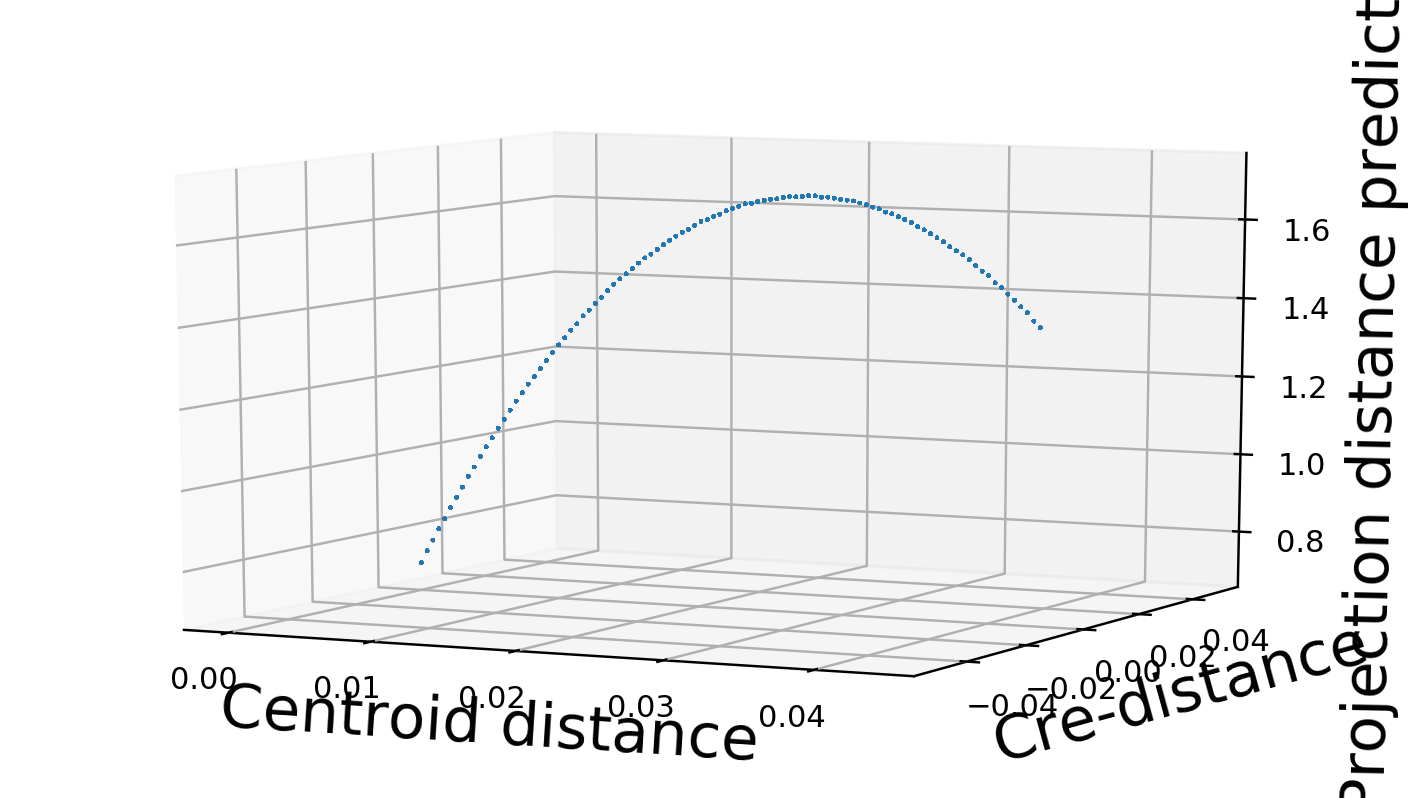

Text(0.5, 0, 'Projection distance predicted')

In [123]:
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
#qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [125]:
from mcmodels.regressors import NadarayaWatson

Text(0.5, 0, 'Projection distance predicted')

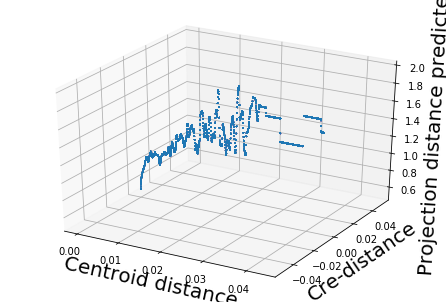

In [151]:
fraction  = .1
qqq = NadarayaWatson(kernel='rbf',  gamma  = 20000000)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
xs = np.linspace(0, dc[:,0].max(), 1000)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((1000,100))
for x in range(1000):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [150]:
xs.shape

(1000,)

In [127]:
sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

In [128]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(119, 5, 1128, 577)
0


In [129]:
meanloss_nw_leaf_leaf2

array([0.34360429])

Text(0.5, 0, 'Projection distance predicted')

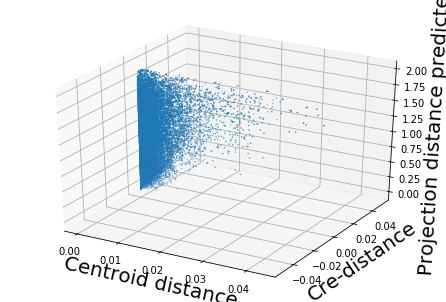

In [152]:

# qqq = NadarayaWatson(kernel='rbf',  gamma  = 200000)
# randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
# qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
# xs = np.linspace(0, dc[:,0].max(), 100)
# ys = np.linspace(0, dc[:,1].max(), 100)
# preds = np.empty((100,100))
# for x in range(100):
#     for y in range(100):
#         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
# mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(dc[:,0], 
           dc[:,1], 
           dc[:,2], s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [136]:
for i in range(ngp):
    print(np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2)
    


0.0
37.994081580294456
78.44564262277947
143.4285871513196
173.53593519184577
117.81479706166583
28.844808391502124
124.15860065642461
2.0075360066753207
18.520423805290797
118.50298028806759
22.620922047458077
185.19316155720813
46.84163810940281
3.271825568020182
2.856916414705115
41.408166049963626
27.31226516688682
0.0
300.2585814307906
158.4887958111316
698.4738758034753
148.5465061742873
133.8157894370264
6.436209782607778
357.79030160288886
357.9783407133434
507.1529146098438
320.25583965313217
629.5998167215237
515.8985886768492
527.8202746976368
170.51985470137734
92.11988914371166
116.61963604778173
663.4744113904992
209.6569355336179
755.5949839167257
534.4865902650107
164.1534136336664
54.88944536767456
316.437279586703
165.22012073572265
4.222703207833187
475.71005409066674
44.3384719058561
325.0256604216179
765.2688224576708
26.80514875973382
423.9610623218681
158.59281327963825
384.11357260254925
7.937676490345822
715.0163241565393
388.34670433326164
863.4342677444757
18

41.31180305876871
34.23816296725379
36.05069315487037
51.600167542185204
138.28564859779536
108.8229090766277
196.94952971830978
17.3110018747924
569.8132793073454
52.40184237212065
10.190785933778246
6.5895629346058815
93.2920596383158
48.36730643402751
48.82556144485992
60.7056840441656
95.9969346923272
60.3978569288885
442.55550988548305
8.633532773070664
98.96312756167411
7.125972079900782
115.01840760948289
9.340825121100979
0.0
166.81960313679045
0.6409277349718008
1.33327645038388
3.2386672774584846
133.59388161004628
154.47897431218476
141.86240409627413
4.099950021121049
8.76184305064532
90.7598031794242
32.86011347127453
68.75061742764579
126.08661516849754
74.4590465338866
107.65057954400439
22.506866951228318
109.16228310074251
6.1982669666970045
7.493459882023247
107.06415633743106
45.21540317239413
132.671890560768
17.654927788333605
193.66949034751477
28.264753511287957
92.96430815954619
13.54523965613162
22.184468037584672
47.88574026709705
5.929845172565178
10.44841095

28.989059031922626
79.26524404074473
38.847771694517505
40.49822735369109
409.4019850193674
65.55669779393529
107.63495042931423
29.409256847918357
0.0
112.27048545792604
25.0933071748525
37.6514129062641
27.408362182396434
751.9520586065449
62.0089047838192
70.40850007769797
14.116499148385666
97.37740328041528
36.24687088579602
35.549978160327335
207.9704855809755
135.49772214648883
33.160072689386695
396.5100284463485
81.63902510260837
171.29023015164694
0.7053196207184922
108.2783379880615
243.10561146788473
175.52252654441835
42.85057722119301
136.467408636617
362.06884641622565
121.70281321625582
12.503586230004224
138.07248943878724
21.445971042798604
72.469893080597
22.334992758632936
81.42695828508695
89.83328517221888
434.96857891478203
127.31307421403376
17.58815428622991
143.318444969631
48.382983998175156
23.786034310569274
239.05783204332695
10.319300487400364
32.65450014610226
17.045434828430547
70.33205153685803
143.97592738582807
118.59808813714878
422.74993352751426
1

237.9229829136885
321.7429118766178
282.66052982193827
211.5202773193257
54.218790491854314
41.53294693651158
127.96500089912331
202.7989402362055
27.34238636228802
72.62468418157438
288.0713917310367
267.8764547892712
15.12633749326547
8.569802834590332
184.56595925741811
3.4088986166624444
220.4742584852094
227.54732862488223
278.11033106244435
70.08832361502688
365.5044377634431
108.45143837647093
108.00849816420875
44.209778977044955
39.79214775701524
242.27264880405374
225.8135366673036
179.6277893868667
84.86253359978416
76.92239512009671
175.95170602017734
130.14271942572663
279.7144777759447
319.9141077540242
67.61292570585336
363.81857156643963
74.42072108548416
53.49816174975699
382.90545178976845
6.414011154145918
225.29048806260724
215.16812110457866
27.31791888504857
200.90252569768774
320.3838666653833
6.1759725593756505
178.36524170234713
14.88322543156354
311.120911535857
152.1883565928273
225.15722739061658
5.501319204224013
259.9316477966427
195.3708856495283
346.4511

18.676018605190553
51.15371761109161
50.816854169385195
16.305671718171336
63.30206583710839
67.76560069060257
83.07068414939918
149.16486460932296
58.45915991607791
206.23519913950346
41.19568721500722
177.41494073618418
95.52589117602851
4.005590670421251
248.39569656376185
84.2049322734125
9.580734632579095
27.11080645428072
1.6397043723653266
3.3546912760219656
0.0
7.6762742514374676
10.038312248027525
0.36991993404179097
6.062201331659259
2.818758539547002
0.35488009156200806
7.057698702945244
14.833663032635036
1.0417252267506656
11.689849123269497
23.574125262796084
4.348380274491082
11.20909792745273
3.743736021809622
5.7213770863073545
3.6926607411771006
1.7521598544846066
3.018986733633795
3.5841052901927615
32.28940007458427
51.20495653053869
82.80679114369444
6.2154435703147906
110.77958064820149
1.687204553904624
105.80055787133813
97.73443536822832
34.95150703868677
17.221184885102314
118.75481610933575
106.4590669363169
93.15575066928315
54.218790491854314
3.920474598558

174.60223093821452
170.78051234448955
79.4477947204549
31.660796826976416
318.14120640215646
302.9406125674986
266.1986402924558
139.62853768923156
131.97408083786922
214.32992233142048
196.70515326789365
379.16560711264697
408.61605068917504
105.46082385819706
473.1664566486558
125.9673441936339
81.14978195495695
454.7257602830719
12.220605697316802
321.60043793250634
289.691851707954
7.477971604897657
292.1731445203442
412.9870664345806
11.722294654172098
250.02720043457956
9.299152305538296
411.42342905341906
216.78807111553914
302.3244262310024
11.686656837677067
362.7106563070093
284.3790716575804
413.176695229645
384.09064198932623
309.17806006687704
372.2528163593878
372.939572162579
0.9927789762025212
69.54814952929358
41.69857262645905
68.19429714292089
29.857223089181204
177.8174417272765
288.96022736448185
14.18248414329498
500.8151206489014
247.34633170187783
81.76172245287124
7.861930560917034
203.95897895585057
66.67924163800913
162.6806808181152
325.45039899412194
399.16

76.52593357334037
19.912766295437915
16.601646392574587
144.50169136556764
7.613346304175635
289.05084760898774
188.92490179107605
78.04985105335473
342.5101221774677
100.31474440338482
39.56816269378435
513.189805642029
84.93026880592592
13.43432549721719
367.7347399144947
43.12407488262653
401.1660525782515
5.225781385521569
58.53633522572948
27.820240448402934
344.47707696891734
80.34995042794708
160.10950515186707
80.62673524084495
48.29018933583675
157.13236546967957
21.82011320257404
107.22867419255084
509.06845923145386
227.2149165506282
293.06110431797987
197.08753969753312
277.8003870346895
79.44450340238588
123.02627073334423
325.7774480708985
4.2693056568706895
146.9438486011722
182.60923566794477
424.0253189011502
222.7841210026801
193.3585336561359
114.25688384080587
26.22259081686978
18.82671504245023
378.6746034358711
185.68397061458407
25.593169495937403
34.31210076189521
153.69658284955727
13.941564033107536
70.27748530272186
264.99597949619715
151.9900426005204
13.002

131.97408083786922
24.91891008315717
97.7311748534231
37.588599807611246
76.42287434075463
115.00152831830556
9.504778325331493
113.7032458743283
4.181541553310995
2.741650524671159
13.155911953883273
120.25570932166222
58.44347950112261
47.172334081610316
38.759315353914964
1.133882145294295
0.0
81.01007498319561
8.408033078861035
63.82660674837138
94.22825566136254
16.730068578868966
106.75372123902886
64.69260282726732
29.913483942933535
168.281234378794
72.32472535774784
61.87946984304359
43.2021520139364
168.33429029784244
44.97345349261119
89.88098653595476
78.20305638563205
25.415975902601247
108.02632292502024
80.3794437877488
19.16041383033114
46.53734968592473
71.87564128937818
73.8478778756816
69.10296971169505
150.0606144849165
70.74103963877268
78.55618669429138
61.73323290878819
86.64654643628512
154.44252453658146
47.71033099066245
69.55982348510031
15.25422145000891
44.351920229629265
3.7641318352496373
54.61370440845555
59.834798679644116
132.70483289720093
107.5999972

5.68453044724714
120.83796090940577
40.412694071060464
85.953694293728
101.43566339959673
224.42295240062955
128.3829424808832
43.22033799972625
206.46098084780863
35.9448953611008
4.310383665396113
234.57851102893372
4.36880791487275
6.492305400003193
208.05395165087367
46.65549794109559
75.02599128497705
29.010188702215327
5.776076376952254
72.34142036121334
47.48613003336628
2.4833171539058694
47.55208304641824
36.103076407218865
87.16688413790087
70.81488264647773
14.350564218641118
48.241644313417595
14.504950599086193
9.51807040383724
26.860495712623862
63.198574159498044
91.39267723019329
16.17651840437037
82.22907301497695
0.0
66.16650898532932
52.171780424058355
56.85717710507532
24.45738941947076
22.786110999401206
45.93768929679482
20.7855903490605
79.42732056093921
12.716415624737788
35.11317025064961
58.787492037850896
8.418585322486402
17.898055933204798
88.36345487086729
43.20791994599128
91.31460864447838
16.411593808648796
35.18228860175718
4.742752330801168
6.91646940

13.892703563322486
68.01493103158427
17.61194536036337
25.166812845700136
15.900741847282362
48.60995582356689
62.28687739051609
45.363399914401505
18.125747540912815
33.73277961348761
42.54205426756886
48.91682561450457
39.18630104901944
9.378693984473397
23.687515594874807
9.41277836170541
25.743085116530555
9.586305490211245
2.99290679091204
11.253996714412418
1.3772470809090682
0.0
0.906471434262123
7.296689722630446
15.826309263038121
4.336058707966279
1.3096743798147568
4.281679753468162
3.08500973598184
2.833391489383833
0.0
72.08881009873406
95.09160322842594
15.783329853282797
1.0727343377433902
11.422104483269703
9.79844295796781
21.09444862033482
13.962643136428948
18.395468119035424
32.32243050281803
122.86340976600104
150.57402582558424
59.60928475856251
80.18240419803354
1.8774158520158535
142.6106883321539
149.82095256570636
178.50756070649706
265.46000354455873
38.322085874972075
104.44310584227772
225.29048806260724
106.54057856402201
80.55861901377315
145.788626589093

9.012892112745451
108.56076059656445
127.31307421403376
68.73187981350318
141.4198357806782
135.10828607168813
120.82381590881057
774.188293238426
104.19128532595879
157.06381234515342
94.31654253879938
206.09436520759866
148.97177346960925
85.05334190226289
146.8365750140668
2.415204467487679
148.98084694520693
420.93949980993733
24.838074834520988
156.03344975978524
145.54346834160594
341.8912101563828
206.61980082122275
4.933391390697618
85.58263278444235
2.6095093655250152
353.38379450019244
111.58595058625475
84.96202313871903
282.5028121548579
113.56928916108232
31.437213308373327
67.64214574138038
41.094075743309766
53.417062378243294
464.3737386839252
0.0
55.49610002266506
76.58017007697556
133.8397235356114
108.15140212726348
244.4680687265158
130.80851428845583
68.71768262457603
93.15451591443812
190.68055015518198
3.90738055063688
1.3757217668959723
489.5732414706923
123.84022937827602
330.82477636962227
91.43660228705816
1.4973702194316951
116.65839652775769
16.753412396424

43.591824142418076
12.055544057878878
23.167240171206945
30.85056108313604
150.14362997555534
43.55476785951898
15.981243013670577
6.002290657314733
33.50023715826489
21.820647364304506
47.341423943455396
80.38897851131972
27.981580156416268
23.199273553486787
127.21333905800479
218.09016290930342
84.71935528433403
135.38934800180934
25.7379357549495
13.490101088658957
105.80413762980079
3.0661789438830755
19.173886819593342
86.2035264175109
39.29788316816821
73.71141804747045
71.42613934234267
144.79167886454871
49.644905378787435
116.24740522619386
49.218355096415785
12.210710952465258
167.19460652601632
37.81641985521935
1.069463701853142
17.479851586926223
15.434654110899164
195.81786537227123
104.80346803767604
559.5273388949623
102.00461696612378
86.11929028678217
33.46197245749691
237.94182010765357
252.06291236838027
386.13997749739383
239.05783204332695
483.4438238513052
401.06858845382965
420.86317317336835
108.22192734936182
160.49878057194366
60.587935293079966
523.61718159

15.50565424072338
2.213177263925097
5.530635562690376
4.5043138031732886
7.493459882023247
110.89334519514723
8.515722027223624
10.21784101847872
4.039219636307321
87.97237056367689
108.4053773697575
99.30843669042744
8.556508514735103
6.83539517889377
53.20649458591461
11.515068022233647
31.735233825033234
78.81977751165901
38.20833051398039
64.43870522154658
4.136762101233221
73.86743337443755
3.2990094950302287
0.0
73.72033793056784
19.80833348527738
89.97436551230844
4.1571214227845585
138.87883914017536
10.881666859706266
55.251471442044725
4.4147094402511815
4.537531155228087
22.492521974739358
2.333144942596038
0.5068815093936551
2.175326624141937
272.21055096492785
159.9196497004332
688.4036083510927
146.84138960807118
135.22189523004695
6.670184188506792
335.07899942936365
329.20103082534075
497.3973258448219
320.2361620724908
602.583752788804
510.8281068527262
520.1757292155539
169.73376496743265
98.71203989632356
110.84750886540215
652.2931578888628
205.9739672254309
745.981

45.45138155690563
94.82809771383523
49.46759122122373
164.75622329434114
115.33527669224777
601.7939953043269
3.1500153708578966
177.9863141830086
19.727197476576215
51.329325143445125
19.6039206299222
16.763893012762807
18.867677996224785
5.225657860988608
7.270914073725229
0.0
21.30218016635151
14.145717956667491
19.540352322847507
47.33562863979877
5.26887818336933
2.185165345189392
11.874282628543007
2.297515237565609
17.49646877605398
0.0
28.2314783819865
62.516473203151214
178.56003384798953
163.78233478540912
104.32117863263049
97.48507746614105
14.546766138529225
203.33810033474455
138.3444706057876
191.55753675330436
336.97313263225135
16.299545385005025
159.2420394374595
215.88749209985622
116.93247504825634
95.16977260150507
203.61824110433406
243.79876457442015
299.7711220041319
72.81777053213632
115.18340280706596
107.2753364409991
102.74218171684387
7.214262708368241
162.45789297484083
60.517689441523
53.88347304687089
40.82752086435947
147.3200562404462
309.1780600668770

5.569696849824594
26.5519712252734
0.0
58.420203913094596
7.557044973463019
41.58975402124441
7.611985722741494
62.83243307674654
58.40937575921244
22.688165145696168
112.10865882369129
92.43250108934699
12.177642656991843
12.159972842608873
42.96203700137329
38.339497584314756
48.486028066038685
7.132737379713715
51.4815375597358
55.110884456345865
77.2351377613018
54.393162373392514
102.22777232716332
94.58305101471433
43.426323573593066
113.81626558034336
23.25030898806298
9.472119019792517
45.246560804541105
77.85060651895907
87.51038305503388
15.335771559647931
14.108180203317758
17.94516495996626
2.6678067224690336
42.16045173037619
38.146968053051914
10.5104199772633
48.12516122787913
41.78503760555594
47.642130263884496
177.8174417272765
11.543805237849668
136.99053660819703
17.748864786380693
58.277393193222096
93.03019758844412
14.191170116866985
79.44450340238588
2.860889822431102
0.0820029707701909
24.567313150633513
152.69282659804136
35.24624182539256
26.365293261429144
3

38.5109890289952
30.024968673116497
0.8892094004999535
45.50881674665913
93.71995385087456
86.97487561935705
106.49105078253734
16.907270501692338
18.211343022735047
60.35179282488055
39.059770546688995
140.69531397510676
146.64845407588905
5.724560666346332
194.51859562986218
91.16834068072251
4.159132061012054
188.7860325498168
22.786515328876717
144.61229407144987
78.51461008612485
84.24944519194274
119.28069763959687
149.00129229721074
28.888484443922682
59.70714254305014
41.70509629206412
156.06765619408125
43.591824142418076
86.3173709822924
23.153715666965702
164.90584245930293
145.3469356044413
164.4501923198875
158.804690502621
161.08753236634018
131.49120362070013
181.69243183089745
83.16797668994606
9.234087533846777
17.033578822217258
1.5291590839859446
7.834727297490069
32.43454240615279
128.98725335329883
21.431416663369028
207.49341722114758
84.67625718425965
3.137595759189835
48.88199048505884
120.10333423348425
0.0
23.732201201620192
107.96719986120085
142.175188318457

868.5340620749656
71.11140901627844
477.2337773696111
116.02464510314051
60.765945217171634
590.5461220777809
195.5635542323559
237.88949394959857
179.6058751299769
802.4556586247573
19.96799581212284
62.14915837394198
15.511659887438993
209.39949831684132
58.58222275068058
163.90154326668912
47.21787758416058
38.25973241141799
927.4573755740726
175.5312039777832
122.62449120527843
46.521287861528364
281.6788122755532
50.259444464508526
611.4340383077808
182.42544225006793
201.2553262332669
182.99558624891708
10.523300780376196
151.23073273284373
151.46403272425425
928.4065177207374
49.08468354394813
743.6359842424213
149.04550415802686
175.06767986128042
247.75347676965256
263.76909496549683
67.68321789568404
215.91007365598958
19.379524845542555
753.2922383802202
547.0307686472331
241.53748359753195
76.37708944188944
395.13190069471545
91.89016231977779
0.0
48.68114883940622
254.86764495550378
48.831772859504674
180.70116461593457
60.19596844421649
41.95787237835268
123.1187360213551

140.86844877596636
47.20793619950921
211.74093200557536
123.31235306543995
8.521090085156864
196.2122361799025
19.21987500804668
629.7916662134159
398.31457634334606
107.30543946417532
49.43255519581339
276.05305703397386
118.53782945562693
60.19596844421649
106.15697125023993
190.5951827598856
123.18473793988294
53.17488450217121
0.0
48.46968143158567
109.15845907081967
166.2477919461479
82.76159324738153
262.3623626345157
137.2320860631825
81.97030429130321
901.1149200572564
137.17513569473726
48.72236734844168
18.692174682810524
241.27080356295926
77.8365810977172
158.8343629702904
76.56725307411607
247.1844538645676
186.34956585237322
736.553783859364
17.991354571058572
246.4203102942066
51.21624627568129
28.695107378731606
446.4704537211557
67.18087648668501
89.95209392212692
33.62178019351232
88.11489831622464
106.13976232088963
540.2336896057242
34.23816296725379
54.43911938942878
6.771817723560768
27.87940120453508
28.392322104064867
14.05647250087231
12.33379468505414
81.64552

0.3510740835583232
386.2041672930363
250.10269771884484
293.9552131054019
152.85165124866506
224.2424469694805
68.30757414274665
4.3523984274202565
235.15064210405166
146.75827763479455
315.8160937677585
196.20279686446037
363.6750052202115
37.253079292051936
170.25097980894597
175.132861893223
44.77387696406416
159.41363621794272
283.901725039572
160.32343849356252
82.20969838588822
81.1377104214356
242.78199393207404
72.99838822115248
261.0639096583893
218.77235310293378
148.39870874574845
121.5403877559406
227.7148589267169
337.9681278992785
44.56032289601558
4.624879796175637
114.76685672919074
192.01803677918664
0.0
86.33415326981238
169.54062362771205
185.0538321058126
162.9233599698581
285.34664895061195
176.83097936865403
254.90295175292363
40.16775818336125
240.0988405855731
172.10343443317677
52.63874514349595
329.68961282235483
172.73810142307764
86.4519088695978
69.92155201580255
114.3018221416378
111.09093403966745
17.901690592001756
10.98433760293982
252.3641141266164
70.

85.76085286861185
213.50322271849092
176.69268687756633
17.773821299547304
264.4376497979561
182.3886319057943
6.492305400003193
173.30645293944102
29.294405764895778
251.1559085032301
108.7452799158301
69.89447547818061
215.51972882230424
187.9281116925729
40.8506664405229
95.91413980576405
33.82932194876948
218.2341740712429
73.71141804747045
118.47185092588818
31.39448253815851
272.7474275621215
259.74071142318047
147.64917730306917
252.84530213292598
279.9001834764752
195.522593842982
298.7730691030136
88.60704999580233
1.3763836340901245
4.815953784673007
26.160260772526566
19.3480296120111
79.69900644263225
233.2885200961943
41.30651504399716
251.8783715987568
53.438474867637005
8.496763714888843
39.36390369185518
228.07470027497055
17.189182817560077
29.37390031432009
173.6933835997271
167.03513210268278
42.515678752231636
22.29147974427324
155.7938970814271
121.10381121641967
16.306190191225244
175.41242449966654
127.50285666930661
16.514132001112163
23.856652489274225
166.0088

36.85121995167525
16.849228002433204
45.22970252427424
13.96855558180866
141.27225389863517
268.16331411020565
8.466095543514452
423.4237521878453
179.3732007090383
48.64790293466988
1.0405362393802138
203.92499440538083
40.833327294252165
114.14550048891492
276.01125068376507
325.27020670435303
4.069661280561217
41.88279034878869
280.68274269611715
230.06461677694347
100.63221192181517
299.03799168165614
294.7092784070896
17.173968577289067
59.770392828767825
310.59952840266914
10.985118958712356
8.783127360253282
145.90817506641392
325.6949008755217
320.89818640523634
179.85990989432003
329.68961282235483
143.41005284289216
78.46821841811055
484.62074999312875
45.410521640456224
39.53065628800154
446.23550862561416
6.852534183459816
142.35010238347175
7.116758904049268
36.379966467586144
199.1379775415999
0.0
47.1512621534421
172.65363875725282
116.26483665043874
61.85216181104371
79.51609904257249
96.3031021301995
1.8524037593912277
144.92462572703175
10.081494675163063
152.92813727

In [137]:
goodpairs

array([[   1,    1],
       [   1,   18],
       [   1,   98],
       ...,
       [1127, 1123],
       [1127, 1124],
       [1127, 1127]])

In [138]:
ds2 = np.zeros(ngp)

for i in range(ngp):
    #print(i)
    ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2

#ds2 = ds[np.where(~np.isnan(cs))]
#

dsnorm  = np.linalg.norm(ds2)



(array([5.177e+03, 3.179e+03, 2.434e+03, 2.094e+03, 1.869e+03, 1.579e+03,
        1.479e+03, 1.443e+03, 1.355e+03, 1.205e+03, 1.130e+03, 1.087e+03,
        9.460e+02, 9.250e+02, 8.100e+02, 7.340e+02, 6.470e+02, 6.020e+02,
        5.460e+02, 5.130e+02, 4.480e+02, 3.960e+02, 3.960e+02, 3.560e+02,
        3.830e+02, 3.020e+02, 3.090e+02, 2.960e+02, 2.400e+02, 2.130e+02,
        1.710e+02, 1.780e+02, 1.780e+02, 1.400e+02, 1.690e+02, 1.510e+02,
        1.530e+02, 1.100e+02, 8.600e+01, 8.800e+01, 1.010e+02, 8.800e+01,
        6.500e+01, 8.800e+01, 6.000e+01, 3.900e+01, 5.700e+01, 4.600e+01,
        3.800e+01, 3.800e+01, 4.400e+01, 4.600e+01, 3.700e+01, 2.700e+01,
        2.900e+01, 3.100e+01, 3.300e+01, 2.900e+01, 2.500e+01, 2.700e+01,
        2.100e+01, 2.600e+01, 2.400e+01, 1.400e+01, 2.000e+01, 1.800e+01,
        1.800e+01, 1.600e+01, 1.300e+01, 7.000e+00, 1.300e+01, 1.700e+01,
        1.000e+01, 1.100e+01, 2.000e+01, 1.000e+01, 1.900e+01, 1.000e+01,
        1.300e+01, 1.400e+01, 1.800e+0

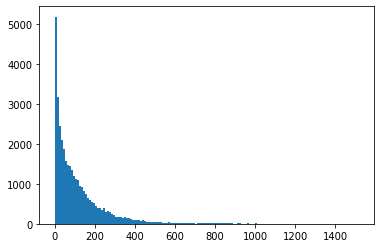

In [144]:
%matplotlib inline
plt.hist(ds2, bins = 150)

In [140]:
dsnorm

35022.697887881375

In [ ]:
dc[:,0]

(array([5.177e+03, 3.179e+03, 2.434e+03, 2.094e+03, 1.869e+03, 1.579e+03,
        1.479e+03, 1.443e+03, 1.355e+03, 1.205e+03, 1.130e+03, 1.087e+03,
        9.460e+02, 9.250e+02, 8.100e+02, 7.340e+02, 6.470e+02, 6.020e+02,
        5.460e+02, 5.130e+02, 4.480e+02, 3.960e+02, 3.960e+02, 3.560e+02,
        3.830e+02, 3.020e+02, 3.090e+02, 2.960e+02, 2.400e+02, 2.130e+02,
        1.710e+02, 1.780e+02, 1.780e+02, 1.400e+02, 1.690e+02, 1.510e+02,
        1.530e+02, 1.100e+02, 8.600e+01, 8.800e+01, 1.010e+02, 8.800e+01,
        6.500e+01, 8.800e+01, 6.000e+01, 3.900e+01, 5.700e+01, 4.600e+01,
        3.800e+01, 3.800e+01, 4.400e+01, 4.600e+01, 3.700e+01, 2.700e+01,
        2.900e+01, 3.100e+01, 3.300e+01, 2.900e+01, 2.500e+01, 2.700e+01,
        2.100e+01, 2.600e+01, 2.400e+01, 1.400e+01, 2.000e+01, 1.800e+01,
        1.800e+01, 1.600e+01, 1.300e+01, 7.000e+00, 1.300e+01, 1.700e+01,
        1.000e+01, 1.100e+01, 2.000e+01, 1.000e+01, 1.900e+01, 1.000e+01,
        1.300e+01, 1.400e+01, 1.800e+0

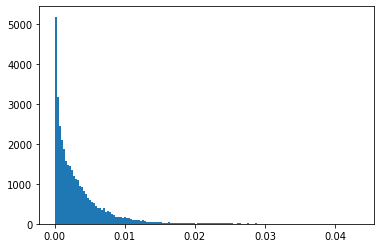

In [145]:
plt.hist(dc[:,0], bins = 150)